In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd

In [2]:
import sklearn
from sklearn.linear_model import LinearRegression
#rom sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LassoLars

from sklearn.linear_model import TweedieRegressor

from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [3]:
def get_ranks(good_df,ypred):
    cutoff=0.2
    #print (codedata,ypred,ydata)
    #print (len(ypred),len(good_df.mm.to_list()))
    d = {'code':good_df.code.to_list(),'pred':ypred,
         "dockQ":good_df.dockQ.to_list(),"params":good_df.params.to_list(),
        "mm":good_df.mm.to_list()}
    res_df=pd.DataFrame(d).sort_values("pred")
    #res_df.sort_values("CODE")

    i=0
    sumdiff=0
    mmdiff=0
    correct=0
    for code in res_df.code.unique():
        topranked=res_df.loc[res_df.code==code].sort_values("pred")["dockQ"][-1:].max()
        best=res_df.loc[res_df.code==code]["dockQ"].max()
        mmtop=res_df.loc[res_df.code==code].sort_values("pred")["mm"][-1:].max()
        mmbest=res_df.loc[res_df.code==code]["mm"].max()
        #print (code,topranked,best)
        if best>cutoff:
            i+=1
            sumdiff+=best-topranked
            mmdiff+=mmbest-mmtop
            if topranked>cutoff:
                correct+=1
    #print (i,correct,round(sumdiff/i,3))            
    return (i,correct,sumdiff,mmdiff)

In [4]:
reg = LinearRegression()
#reg=RandomForestClassifier(n_estimators=10)
#reg=LassoLars(alpha=.1)
#reg = TweedieRegressor(power=1, alpha=0.5, link='log')
#reg=TheilSenRegressor(random_state=42)
#reg=RANSACRegressor(random_state=42)
#reg=HuberRegressor()

In [5]:
df=pd.read_csv("~/Downloads/summary.csv",sep=",")
df=df.dropna()
#df.JHparams.unique()

In [6]:
sns.set(style="whitegrid")

In [7]:
df["name"]
df.keys()

Index(['name', 'JHparams', 'lenA', 'lenB', 'msa', 'msaA', 'msaB', 'cdhit',
       'dockQ', 'fnat', 'iRMS', 'LRMS', 'fnonnat', 'mm', 'tmA', 'tmB', 'long',
       'med', 'longPPV', 'medPPV', 'longA', 'medA', 'longPPVA', 'medPPVA',
       'longB', 'medB', 'longPPVB', 'medPPVB', 'short', 'shortPPV', 'shortA',
       'shortPPVA', 'shortB', 'shortPPVB', 'shortpdb', 'medpdb', 'longpdb',
       'avprob', 'auc', 'evalue', 'seqid', 'hhprob', 'hhevalue', 'hhscore',
       'rank'],
      dtype='object')

In [8]:

df["code"]=df["name"].str[:4]
df["CODE"]=df["code"]
df["params"]=df["JHparams"]

In [9]:
r=re.compile("^PDB|^pdb|^TMd|gramm")
datasets=df.JHparams.unique()
notRosettaset=list(filter(r.match, datasets))
df2=df.loc[~df.JHparams.isin(notRosettaset)].copy()
df2.JHparams="trRosetta"
df2.params="trRosetta"


In [10]:
df=pd.concat([df,df2], ignore_index=True,sort=False)
df.fillna(0)
#df.JHparams.unique()


,name,JHparams,lenA,lenB,msa,msaA,msaB,cdhit,dockQ,fnat,...,auc,evalue,seqid,hhprob,hhevalue,hhscore,rank,code,CODE,params
0,1b27_u1_A-1b27_u2_A,-N 3 --cpu 8,109,90,733.0,1484.0,2034.0,654,0.223,0.12,...,0.46,4.30,50.000,1.8,0.027,13.5,1,1b27,1b27,-N 3 --cpu 8
1,1b27_u2_A-1b27_u1_A,-N 3 --cpu 8,90,109,733.0,2034.0,1484.0,656,0.229,0.16,...,0.46,4.30,50.000,2.5,0.019,13.7,2,1b27,1b27,-N 3 --cpu 8
2,1bdj_u1_A-1bdj_u2_A,-N 3 --cpu 8,129,118,5651.0,349880.0,23051.0,5071,0.000,0.00,...,0.00,9999.00,0.000,0.0,9999.000,0.0,1,1bdj,1bdj,-N 3 --cpu 8
3,1buh_u1_A-1buh_u2_A,-N 3 --cpu 8,291,72,1177.0,555226.0,1820.0,548,0.000,0.00,...,0.00,0.85,30.000,1.6,0.032,14.3,1,1buh,1buh,-N 3 --cpu 8
4,1buh_u2_A-1buh_u1_A,-N 3 --cpu 8,72,291,1177.0,1820.0,555226.0,546,0.001,0.00,...,0.00,0.85,30.000,0.9,0.064,13.1,2,1buh,1buh,-N 3 --cpu 8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6089,2d5r_u1_A-2d5r_u2_A,trRosetta,265,121,521.0,6345.0,1785.0,226,0.000,0.00,...,0.15,0.76,71.429,0.7,0.700,0.7,1,2d5r,2d5r,trRosetta
6090,2d5r_u2_A-2d5r_u1_A,trRosetta,121,265,521.0,1785.0,6345.0,225,0.000,0.00,...,0.41,0.76,71.429,0.8,0.800,0.8,2,2d5r,2d5r,trRosetta
6091,2grx_u1_A-2grx_u2_A,trRosetta,708,91,3344.0,90835.0,14022.0,3313,0.000,0.00,...,0.00,1.50,66.667,0.4,0.400,0.4,1,2grx,2grx,trRosetta
6092,2hj9_u1_A-2hj9_u2_A,trRosetta,339,211,99.0,90876.0,180.0,99,0.000,0.00,...,0.00,0.02,45.000,0.3,0.300,0.3,1,2hj9,2hj9,trRosetta


In [11]:
#df.loc[df.JHparams=="N1-N3-new"]

In [12]:
r=re.compile("^PDB|^pdb")
datasets=df.JHparams.unique()
pdbset=list(filter(r.match, datasets))
df2=df.loc[(df.JHparams.isin(pdbset))&(~df.JHparams.isin(["pdbconfold"]))].copy()
df2.JHparams="PDB"
df2.params="PDB"
df2

,name,JHparams,lenA,lenB,msa,msaA,msaB,cdhit,dockQ,fnat,...,auc,evalue,seqid,hhprob,hhevalue,hhscore,rank,code,CODE,params


In [13]:
df=pd.concat([df,df2], ignore_index=True,sort=False)
#df.fillna(0)
#df.params.unique()

In [14]:
# Add a linear combination of trRosetta
r=re.compile(".*-N.*") # .*cpu.*
datasets=df.JHparams.unique()
JHsets=list(filter(r.match, datasets))



In [15]:
cutoff=0.1
goodmodels=df.loc[(df.dockQ>cutoff)&(df.JHparams.isin(JHsets))].code.unique()
good_df=df.loc[(df.code.isin(goodmodels))&(df.JHparams.isin(JHsets))] #.reset_index()
#df.dockQ.dtypes

Text(0.5, 1.0, 'CC 0.327 Good: 0.444 Loss: 0.15 , 0.203 Test: 9')

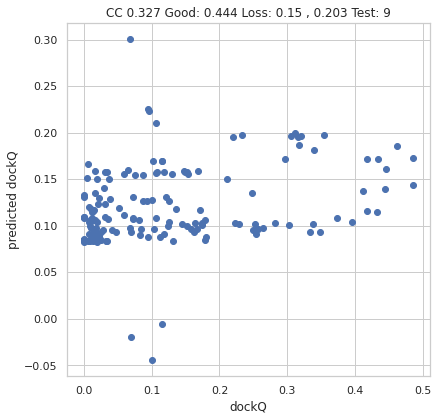

In [16]:
ydata=good_df.dockQ

#cols=["lenA","lenB","msa","long","med","longA","medA","longB","medB","tmA","tmB"]
#xdata=good_df[["lenA","lenB","long","med"]]
#cols=["longA","longB","medA","medB","tmA","tmB"]
cols=["med","long","msa"]
#cols=["msa"]
xdata=good_df[cols]
reg.fit(xdata,ydata)
ypred = reg.predict(xdata)
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(ydata,ypred)
cc=np.corrcoef(ydata,ypred)
ax.set_xlabel("dockQ")
ax.set_ylabel("predicted dockQ")
(i,j,dockq,mm)=get_ranks(good_df,ypred)
#print(i,j,k/i)
ax.set_title("CC" + " " + str(round(cc[0,1],3))
            + " Good: " + str(round(j/i,3)) + " Loss: " + str(round(dockq/i,3))
             + " , " + str(round(mm/i,3))
             + " Test: " + str(i)
            )


In [17]:
xdata=df.loc[df.JHparams.isin(JHsets)][cols]
ypred = reg.predict(xdata)
df2=df.loc[df.JHparams.isin(JHsets)].reset_index()
df2.loc[:,'pred'] = ypred
topranked=pd.DataFrame(columns = df2.columns) 


In [18]:

for name in df2.name.unique():
    foo=df2.loc[df2.name==name].sort_values("pred")[-1:].max()
    #print(foo)
    foo_df=pd.DataFrame(foo).transpose()
    #print (foo_df)
    topranked=pd.concat([topranked,foo_df], ignore_index=True)
topranked["JHparams"]="JHranked"
topranked.params="JHranked"
topranked=topranked.drop(["pred","index"],axis=1)
topranked.columns

Index(['name', 'JHparams', 'lenA', 'lenB', 'msa', 'msaA', 'msaB', 'cdhit',
       'dockQ', 'fnat', 'iRMS', 'LRMS', 'fnonnat', 'mm', 'tmA', 'tmB', 'long',
       'med', 'longPPV', 'medPPV', 'longA', 'medA', 'longPPVA', 'medPPVA',
       'longB', 'medB', 'longPPVB', 'medPPVB', 'short', 'shortPPV', 'shortA',
       'shortPPVA', 'shortB', 'shortPPVB', 'shortpdb', 'medpdb', 'longpdb',
       'avprob', 'auc', 'evalue', 'seqid', 'hhprob', 'hhevalue', 'hhscore',
       'rank', 'code', 'CODE', 'params'],
      dtype='object')

In [19]:
df.columns

Index(['name', 'JHparams', 'lenA', 'lenB', 'msa', 'msaA', 'msaB', 'cdhit',
       'dockQ', 'fnat', 'iRMS', 'LRMS', 'fnonnat', 'mm', 'tmA', 'tmB', 'long',
       'med', 'longPPV', 'medPPV', 'longA', 'medA', 'longPPVA', 'medPPVA',
       'longB', 'medB', 'longPPVB', 'medPPVB', 'short', 'shortPPV', 'shortA',
       'shortPPVA', 'shortB', 'shortPPVB', 'shortpdb', 'medpdb', 'longpdb',
       'avprob', 'auc', 'evalue', 'seqid', 'hhprob', 'hhevalue', 'hhscore',
       'rank', 'code', 'CODE', 'params'],
      dtype='object')

In [20]:
df=pd.concat([df,topranked], ignore_index=True,sort=False)
df.fillna(0)
df.params.unique()

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged',
       'N1-N3-merged-fast', 'N1-N3-new', 'N1-N3-multimerged',
       '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged', 'N1-top1000',
       'N1-top100', 'N1-top2000', 'N1-top500', 'N3dock',
       '-N 3 --incE 1.e-2', 'N3-merged', 'N3-multimerged', 'N3-newdockA',
       'N3-newdockB', 'N3-newdockC', 'N5-newdockA', 'trRosetta',
       'JHranked'], dtype=object)

In [21]:
df

,name,JHparams,lenA,lenB,msa,msaA,msaB,cdhit,dockQ,fnat,...,auc,evalue,seqid,hhprob,hhevalue,hhscore,rank,code,CODE,params
0,1b27_u1_A-1b27_u2_A,-N 3 --cpu 8,109,90,733,1484,2034,654,0.223,0.12,...,0.46,4.3,50,1.8,0.027,13.5,1,1b27,1b27,-N 3 --cpu 8
1,1b27_u2_A-1b27_u1_A,-N 3 --cpu 8,90,109,733,2034,1484,656,0.229,0.16,...,0.46,4.3,50,2.5,0.019,13.7,2,1b27,1b27,-N 3 --cpu 8
2,1bdj_u1_A-1bdj_u2_A,-N 3 --cpu 8,129,118,5651,349880,23051,5071,0,0,...,0,9999,0,0,9999,0,1,1bdj,1bdj,-N 3 --cpu 8
3,1buh_u1_A-1buh_u2_A,-N 3 --cpu 8,291,72,1177,555226,1820,548,0,0,...,0,0.85,30,1.6,0.032,14.3,1,1buh,1buh,-N 3 --cpu 8
4,1buh_u2_A-1buh_u1_A,-N 3 --cpu 8,72,291,1177,1820,555226,546,0.001,0,...,0,0.85,30,0.9,0.064,13.1,2,1buh,1buh,-N 3 --cpu 8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6498,5cec_u2_A-5cec_u1_A,JHranked,191,403,8,59695,200,7,0.05,0.075,...,0,19,33.333,0.3,0.21,14.5,2,5cec,5cec,JHranked
6499,5cra_u1_A-5cra_u2_A,JHranked,193,77,1,11,38383,1,0.008,0,...,0,9999,0,1,1,1,1,5cra,5cra,JHranked
6500,5cra_u2_A-5cra_u1_A,JHranked,77,193,1,38383,11,1,0.016,0,...,0.17,9999,0,0.8,0.8,0.8,2,5cra,5cra,JHranked
6501,5eg3_u1_A-5eg3_u2_A,JHranked,303,105,421,565997,25926,205,0,0,...,0,68,40,0.7,0.7,0.7,1,5eg3,5eg3,JHranked


In [22]:
#df["rank"].str.isnumeric().unique()
#df.dtypes

In [23]:
# We need to check that everything is numeric
cols=['name', 'JHparams', 'seqid',      'rank']

#for d in df.columns.values.tolist():
for d in ["rank","len"]:
    if d=="name": continue
    if d=="JHparams": continue
    print (d)
    #print (df.loc[(df[d].str.isnumeric()!=True)][cols+[d]])
    #print (df.loc[(df[d].str.isnumeric()][d].unique()
    #print (df[d].str.isnumeric().unique())

rank
len


In [24]:
# Divide data into datasets


df["tmAB"]=df[["tmA","tmB"]].mean(axis=1)
df["msaAB"]=df[["msaA","msaB"]].mean(axis=1)
df["tmAB_max"]=df[["tmA","tmB"]].max(axis=1)
df["msaAB_max"]=df[["msaA","msaB"]].max(axis=1)
df["tmAB_min"]=df[["tmA","tmB"]].min(axis=1)
df["msaAB_min"]=df[["msaA","msaB"]].min(axis=1)
df["numcorrect"]=df["longPPV"]*df["long"]
df["len"]=df["lenA"]+df["lenB"]

codes=df.code.unique()
df_mean=df.groupby(["JHparams","code"]).mean()
df_max=df.groupby(["JHparams","code"]).max()
df_min=df.groupby(["JHparams","code"]).min()
df_first=df.loc[df["rank"]==1]

In [25]:
df.columns.values.tolist()

['name',
 'JHparams',
 'lenA',
 'lenB',
 'msa',
 'msaA',
 'msaB',
 'cdhit',
 'dockQ',
 'fnat',
 'iRMS',
 'LRMS',
 'fnonnat',
 'mm',
 'tmA',
 'tmB',
 'long',
 'med',
 'longPPV',
 'medPPV',
 'longA',
 'medA',
 'longPPVA',
 'medPPVA',
 'longB',
 'medB',
 'longPPVB',
 'medPPVB',
 'short',
 'shortPPV',
 'shortA',
 'shortPPVA',
 'shortB',
 'shortPPVB',
 'shortpdb',
 'medpdb',
 'longpdb',
 'avprob',
 'auc',
 'evalue',
 'seqid',
 'hhprob',
 'hhevalue',
 'hhscore',
 'rank',
 'code',
 'CODE',
 'params',
 'tmAB',
 'msaAB',
 'tmAB_max',
 'msaAB_max',
 'tmAB_min',
 'msaAB_min',
 'numcorrect',
 'len']

In [26]:
cols=['name', 'JHparams', 'seqid',      'rank']
      
d="TMdock-nohomology"
#df.loc[df.JHparams==d].groupby(["code"])[cols].first()

#df.loc[(df.JHparams==d) & ((df["rank"].str.isnumeric()!=True))][cols]
#df.loc[(df.JHparams==d)]["rank"].str.isnumeric()
#df.loc[(df.JHparams==d)] 
      
      

In [27]:
datasets=df.JHparams.unique()
data_mean={}
data_max={}
data_min={}
for d in datasets:
    #print (d)
    data_mean[d]=df.loc[df.JHparams==d].groupby(["code"]).mean()
    data_max[d]=df.loc[df.JHparams==d].groupby(["code"]).max()
    data_min[d]=df.loc[df.JHparams==d].groupby(["code"]).min()


In [28]:
df.loc[ (df.JHparams=="trRosetta")  & (df["rank"]==1)]

,name,JHparams,lenA,lenB,msa,msaA,msaB,cdhit,dockQ,fnat,...,CODE,params,tmAB,msaAB,tmAB_max,msaAB_max,tmAB_min,msaAB_min,numcorrect,len
3627,1b27_u1_A-1b27_u2_A,trRosetta,109,90,733,1484,2034,654,0.223,0.12,...,1b27,trRosetta,0.824750,1759.0,0.85428,2034.0,0.79522,1484.0,49.025,199
3629,1bdj_u1_A-1bdj_u2_A,trRosetta,129,118,5651,349880,23051,5071,0,0,...,1bdj,trRosetta,0.861435,186465.5,0.92240,349880.0,0.80047,23051.0,0,247
3630,1buh_u1_A-1buh_u2_A,trRosetta,291,72,1177,555226,1820,548,0,0,...,1buh,trRosetta,0.560760,278523.0,0.73259,555226.0,0.38893,1820.0,0,363
3632,1bvn_u1_A-1bvn_u2_A,trRosetta,496,75,95,52623,123,85,0.006,0,...,1bvn,trRosetta,0.619740,26373.0,0.70905,52623.0,0.53043,123.0,0,571
3634,1clv_u1_A-1clv_u2_A,trRosetta,471,33,1,53450,0,1,0.007,0,...,1clv,trRosetta,0.225975,26725.0,0.26604,53450.0,0.18591,0.0,0,504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6088,2b4s_u1_A-2b4s_u2_A,trRosetta,298,298,1128,560200,38771,769,0,0,...,2b4s,trRosetta,0.763125,299485.5,0.76682,560200.0,0.75943,38771.0,0,596
6089,2d5r_u1_A-2d5r_u2_A,trRosetta,265,121,521,6345,1785,226,0,0,...,2d5r,trRosetta,0.788660,4065.0,0.87487,6345.0,0.70245,1785.0,5.994,386
6091,2grx_u1_A-2grx_u2_A,trRosetta,708,91,3344,90835,14022,3313,0,0,...,2grx,trRosetta,0.782855,52428.5,0.83746,90835.0,0.72825,14022.0,0,799
6092,2hj9_u1_A-2hj9_u2_A,trRosetta,339,211,99,90876,180,99,0,0,...,2hj9,trRosetta,0.587300,45528.0,0.70762,90876.0,0.46698,180.0,0,550


In [29]:
df.JHparams.unique()
#datasets

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged',
       'N1-N3-merged-fast', 'N1-N3-new', 'N1-N3-multimerged',
       '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged', 'N1-top1000',
       'N1-top100', 'N1-top2000', 'N1-top500', 'N3dock',
       '-N 3 --incE 1.e-2', 'N3-merged', 'N3-multimerged', 'N3-newdockA',
       'N3-newdockB', 'N3-newdockC', 'N5-newdockA', 'trRosetta',
       'JHranked'], dtype=object)

In [30]:
data_first={}
data_second={}
for d in datasets:
    data_first[d]=df.loc[ (df["JHparams"]==d)  & (df["rank"]==1)]
    data_second[d]=df.loc[ (df["JHparams"]==d)  & (df["rank"]==2)]
data_first[d]

,name,JHparams,lenA,lenB,msa,msaA,msaB,cdhit,dockQ,fnat,...,CODE,params,tmAB,msaAB,tmAB_max,msaAB_max,tmAB_min,msaAB_min,numcorrect,len
6094,1b27_u1_A-1b27_u2_A,JHranked,109,90,733,1484,2034,654,0.174,0.1,...,1b27,JHranked,0.811355,1759.0,0.85249,2034.0,0.77022,1484.0,49.025,199
6096,1bdj_u1_A-1bdj_u2_A,JHranked,129,118,5651,349880,23051,5071,0,0,...,1bdj,JHranked,0.861435,186465.5,0.92240,349880.0,0.80047,23051.0,0,247
6097,1buh_u1_A-1buh_u2_A,JHranked,291,72,1177,555226,1820,548,0,0,...,1buh,JHranked,0.560760,278523.0,0.73259,555226.0,0.38893,1820.0,0,363
6099,1bvn_u1_A-1bvn_u2_A,JHranked,496,75,95,52623,123,85,0.006,0,...,1bvn,JHranked,0.619740,26373.0,0.70905,52623.0,0.53043,123.0,0,571
6101,1clv_u1_A-1clv_u2_A,JHranked,471,33,1,2100,0,1,0.01,0,...,1clv,JHranked,0.291670,1050.0,0.31253,2100.0,0.27081,0.0,0,504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6493,4zfr_u1_A-4zfr_u2_A,JHranked,186,77,1358,9290,38386,490,0,0,...,4zfr,JHranked,0.796765,23838.0,0.83034,38386.0,0.76319,9290.0,0,263
6495,5brr_u1_A-5brr_u2_A,JHranked,378,266,76,196,411,31,0.008,0,...,5brr,JHranked,0.291110,303.5,0.29169,411.0,0.29053,196.0,203,644
6497,5cec_u1_A-5cec_u2_A,JHranked,403,191,1594,30621,309307,1577,0,0,...,5cec,JHranked,0.768860,169964.0,0.84687,309307.0,0.69085,30621.0,0,594
6499,5cra_u1_A-5cra_u2_A,JHranked,193,77,1,11,38383,1,0.008,0,...,5cra,JHranked,0.546110,19197.0,0.71106,38383.0,0.38116,11.0,0,270


In [31]:
#datasets


In [32]:
df_test= data_first["N1-merged"]
#data_first["N1-merged"].tmA
df_test["tmB"]


2080     0.7694
2082    0.82667
2084    0.76059
2086    0.89115
2088     0.7344
         ...   
2231    0.87013
2233    0.18153
2235     0.8446
2236    0.83401
2238    0.79529
Name: tmB, Length: 82, dtype: object

In [33]:
df_merged = pd.merge(data_first["trRosetta"],data_first[d], on=['code'],how="inner")
plt.scatter(df_merged.dockQ,df_merged.mm)

AttributeError: 'DataFrame' object has no attribute 'dockQ'

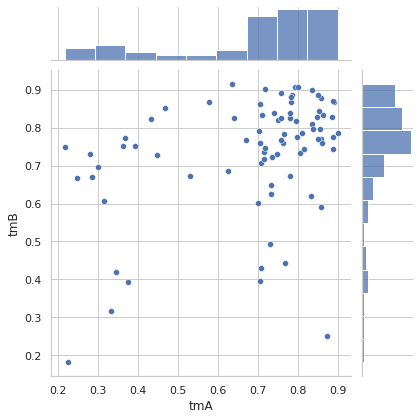

In [34]:

df_test= data_first["N1-merged"]
#plt.scatter(df_test.tmB,df_test.tmA)


sns_plot = sns.jointplot(data=df_test, x="tmA", y="tmB")
sns_plot.savefig("tmA-tmB.png")



In [35]:
df_test.loc[(df_test.tmA>0.8 )&(df_test.lenA>300)]["name"]


2088    1gg2_u1_A-1gg2_u2_A
2104    1nbf_u1_A-1nbf_u2_A
2120    1wq1_u1_A-1wq1_u2_A
2129    1zlh_u1_A-1zlh_u2_A
2174    3a8i_u1_A-3a8i_u2_A
2192    3qlu_u1_A-3qlu_u2_A
2197    4bmp_u1_A-4bmp_u2_A
2213    4o4b_u1_A-4o4b_u2_A
2235    5brr_u1_A-5brr_u2_A
2238    5eg3_u1_A-5eg3_u2_A
Name: name, dtype: object

KeyError: 'PDB'

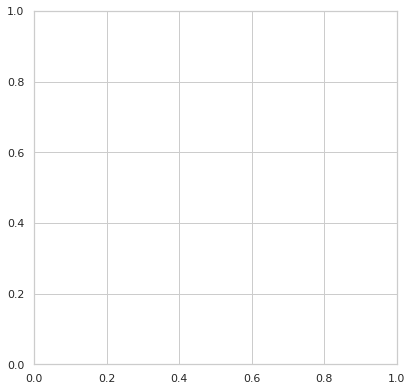

KeyError: 'PDB'

In [36]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
df_merged = pd.merge(data_max["PDB"],data_max["trRosetta"], on=['code'],how="inner")
plt.scatter(df_merged.tmAB_x,df_merged.tmAB_y,label=d)
ax.set_title("TM scores best model ")
ax.set_xlabel("TM PDB ")
ax.set_ylabel("TM trRosetta")



Text(0, 0.5, 'dockQ')

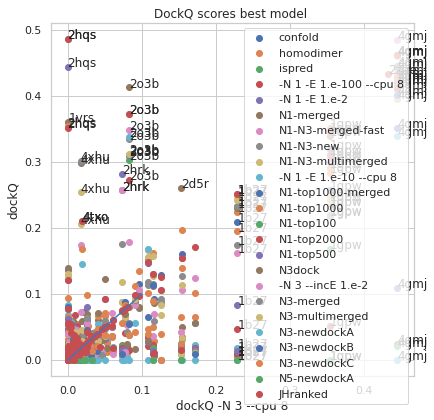

In [37]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in datasets:
    if d == datasets[0]: continue
    if d=="gramm":continue   
    if d[0:3]=="PDB":continue   
    if d[0:3]=="pdb":continue   
    if d[0:3]=="TMd":continue   
    if d=="trRosetta":continue   
    #if d=="confold":continue   
    #if d=="rbh-merged-pdb":continue   

    df_merged = pd.merge(data_max[datasets[0]],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4] # +d
        except:
            sstr=df_merged.name_y[i][0:4] #+d
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.1]
y=[0,0.1]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores best model ")
ax.set_xlabel("dockQ "+str(datasets[0]))
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'numcorrect')

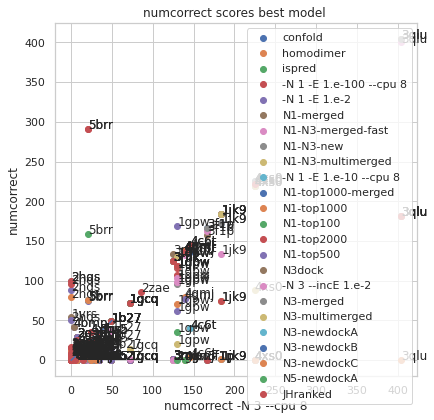

In [38]:
cutoff=5
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in datasets:
    if d == datasets[0]: continue
    if d=="gramm":continue   
    if d=="trRosetta":continue 
    if d[0:3]=="PDB":continue   
    if d[0:3]=="pdb":continue   
    if d[0:3]=="TMd":continue   
        
    #if d=="confold":continue   
    #if d=="rbh-merged-pdb":continue   

    df_merged = pd.merge(data_max[datasets[0]],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.numcorrect_x,df_merged.numcorrect_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.numcorrect_x[i]> cutoff or df_merged.numcorrect_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.numcorrect_x[i], df_merged.numcorrect_y[i]))
x=[0,50]
y=[0,50]
plt.plot(x,y)
ax.legend()
ax.set_title("numcorrect scores best model ")
ax.set_xlabel("numcorrect "+str(datasets[0]))
ax.set_ylabel("numcorrect")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ')

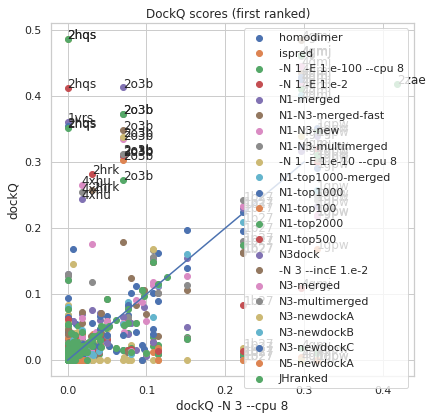

In [39]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in datasets:
    if d == datasets[0]: continue
    if d=="gramm":continue   
    if d=="trRosetta":continue   
    if d=="confold":continue   
    #if d=="rbh-merged-pdb":continue   
    if d[0:3]=="PDB":continue   
    if d[0:3]=="pdb":continue   
    if d[0:3]=="TMd":continue   
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_first[datasets[0]],data_first[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.3]
y=[0,0.3]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (first ranked)  ")
ax.set_xlabel("dockQ "+str(datasets[0]))
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ')

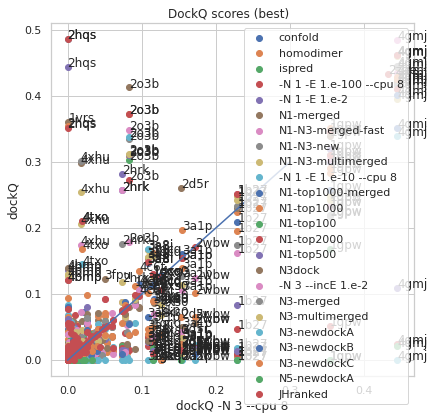

In [40]:
cutoff=0.1
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in datasets:
    if d == datasets[0]: continue
    if d=="gramm":continue   
    if d=="trRosetta":continue   
    if d=="rbh merge pdb ":continue   
    if d[0:3]=="PDB":continue   
    if d[0:3]=="pdb":continue   
    if d[0:3]=="TMd":continue   
        
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max[datasets[0]],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.3]
y=[0,0.3]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (best)  ")
ax.set_xlabel("dockQ "+str(datasets[0]))
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

KeyError: 'N1-merged-pdb'

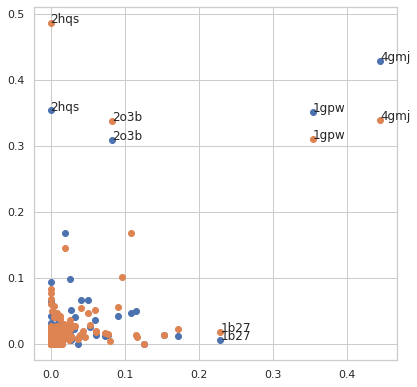

KeyError: 'N1-merged-pdb'

In [41]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["N1-top1000","-N 1 -E 1.e-10 --cpu 8 ","N1-merged-pdb"]:
    if d == datasets[0]: continue
    if d=="gramm":continue   
    if d=="trRosetta":continue   
    if d=="rbh merge pdb ":continue   
    if d[0:3]=="PDB":continue   
    if d[0:3]=="pdb":continue   
    if d[0:3]=="TMd":continue   
        
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max[datasets[0]],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.6]
y=[0,0.6]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (best)  ")
ax.set_xlabel("dockQ "+str(datasets[0]))
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [42]:
data_max.keys()

dict_keys(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred', '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged', 'N1-N3-merged-fast', 'N1-N3-new', 'N1-N3-multimerged', '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged', 'N1-top1000', 'N1-top100', 'N1-top2000', 'N1-top500', 'N3dock', '-N 3 --incE 1.e-2', 'N3-merged', 'N3-multimerged', 'N3-newdockA', 'N3-newdockB', 'N3-newdockC', 'N5-newdockA', 'trRosetta', 'JHranked'])

KeyError: 'TMdock-double'

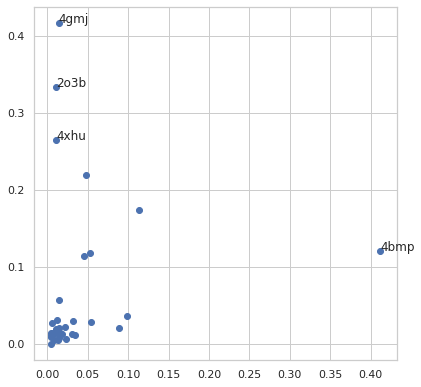

KeyError: 'TMdock-double'

In [43]:
cutoff=0.23
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["N1-N3-new","TMdock-double"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_first["gramm"],data_first[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,1.0]
y=[0,1.0]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (first)  ")
ax.set_xlabel("dockQ - gramm")
ax.set_ylabel("dockQ ")

plt.savefig("tr-tn-gramm.png")
#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

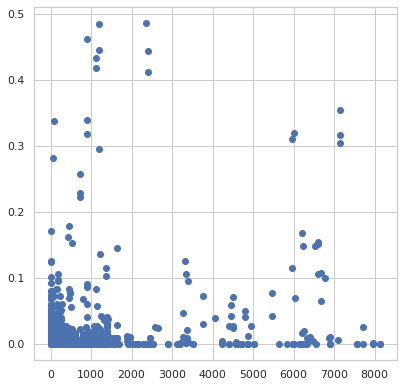

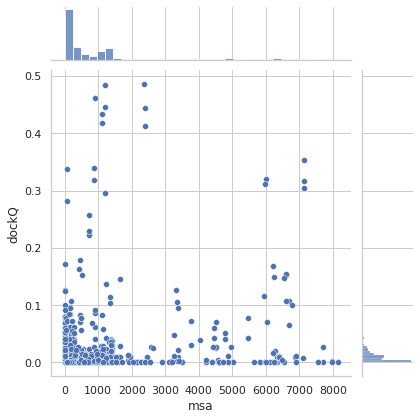

In [44]:
selset=['-N 3 --cpu 8', '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ',  '-N 1 -E 1.e-10 --cpu 8 ',  '-N 3 --incE 1.e-2', '-N 5 --cpu 8']
#codes=df_max.loc[df_max.params.isin(selset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=df.loc[(df.JHparams.isin(selset))]
plt.scatter(tempdf.msa,tempdf.dockQ)
plt.savefig("msa-dockq-scatter.png")
sns_plot=sns.jointplot(data=tempdf,x="msa",y="dockQ")
sns_plot.savefig("msa-dockq.png")


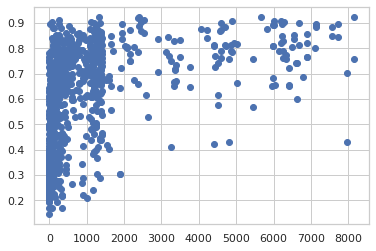

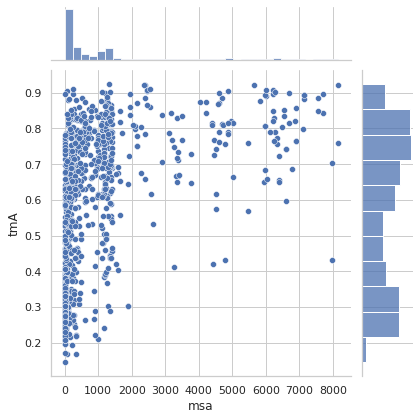

In [45]:
tempdf=df.loc[(df.JHparams.isin(selset))]
plt.scatter(tempdf.msa,tempdf.tmA)
#print (tempdf["msaA"])
#tempdf["logmsaA"]=np.log10(tempdf["msa"]+0.0000001)
plt.savefig("msa-tm-scatter.png")
sns_plot=sns.jointplot(data=tempdf,x="msa",y="tmA")
sns_plot.savefig("msa-tm.png")


KeyError: 'TMdock-double'

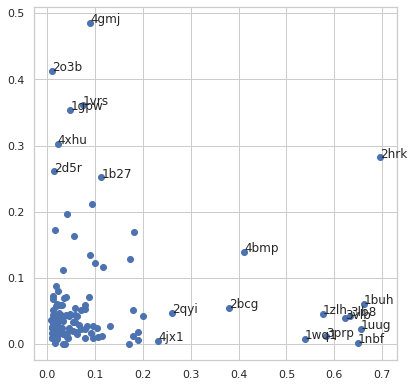

KeyError: 'TMdock-double'

In [46]:
cutoff=0.23
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["trRosetta","TMdock-double"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["gramm"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,1.0]
y=[0,1.0]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (best)  ")
ax.set_xlabel("dockQ - gramm")
ax.set_ylabel("dockQ ")

plt.savefig("tr-tn-gramm-best.png")


NameError: name 'newdf' is not defined

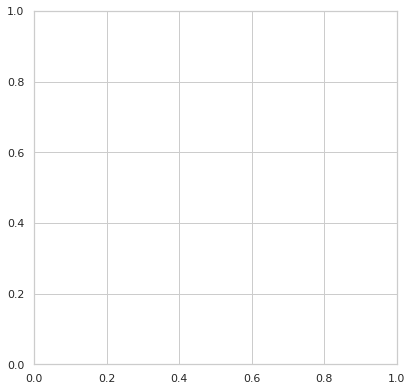

NameError: name 'newdf' is not defined

In [47]:
# FInd best method for each model.
selset=["gramm","TMdock-double","trRosetta"]
#codes=df_max.loc[df_max.params.isin(selset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=df.loc[(df.JHparams.isin(selset))&(df.rank==1)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(selset))].reset_index()
#plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
#plt.scatter(best_df.dockQ,best_df.JHparams,color="red")


all_df=df_max.loc[(df_max.CODE.isin(codes))&(df_max.params.isin(selset))].reset_index()
plt.scatter(all_df.dockQ,all_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(selset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    i+=1
    print (d)
    
print (data)    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(all_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    #numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[all_df.JHparams[i]]==0:
        done[all_df.JHparams[i]]=1
        #ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[all_df.JHparams[i]],3))+"("+str(length[all_df.JHparams[i]])+")"
                    ,(1.0, all_df.JHparams[i]))
#sns.jointplot(data=df_merged,x=

plt.savefig("tm-tr-gramm-best-violin.png")


NameError: name 'newdf' is not defined

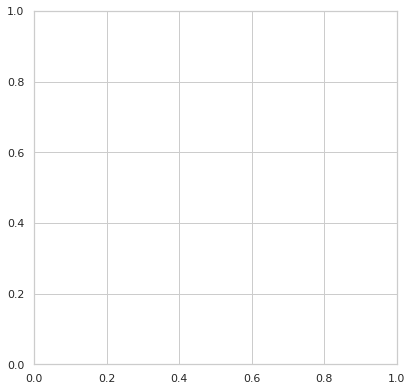

NameError: name 'newdf' is not defined

In [48]:
# FInd best method for each model.
selset=["gramm","TMdock-double","N1-N3-new"]
#codes=df_max.loc[df_max.params.isin(selset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=df.loc[(df.JHparams.isin(selset))&(df.rank==1)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(selset))].reset_index()
#plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
#plt.scatter(best_df.dockQ,best_df.JHparams,color="red")


all_df=df_first.loc[(df_first.CODE.isin(codes))&(df_first.params.isin(selset))].reset_index()
plt.scatter(all_df.dockQ,all_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("First ranked models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(selset):
    done[d]=0
    average[d]=all_df.loc[all_df.CODE.isin(codes)&(all_df.params==d)]["dockQ"].mean()
    length[d]=len(all_df.loc[all_df.CODE.isin(codes)&(all_df.params==d)]["dockQ"])
    pos+=[i]
    data+=[all_df.loc[all_df.CODE.isin(codes)&(all_df.params==d)]["dockQ"]]
    i+=1
    print (d)
print (data)    
ax.violinplot(data,pos)
#, points=80, vert=False, widths=0.7,
#                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(all_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    #numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[all_df.JHparams[i]]==0:
        done[all_df.JHparams[i]]=1
        #ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[all_df.JHparams[i]],3))+"("+str(length[all_df.JHparams[i]])+")"
                    ,(1.0, all_df.JHparams[i]))
#sns.jointplot(data=df_merged,x=

plt.savefig("tm-tr-gramm-violin.png")


Text(0, 0.5, 'dockQ ')

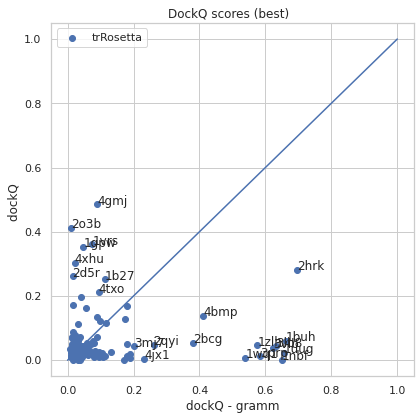

In [49]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["trRosetta"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["gramm"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,1.0]
y=[0,1.0]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (best)  ")
ax.set_xlabel("dockQ - gramm")
ax.set_ylabel("dockQ ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [50]:
d="TMdock"
foo=pd.merge(data_first["gramm"],data_first[d], on=['code'],how="inner")
data_first[d].dockQ
foo[["dockQ_x","dockQ_y"]]
#cc=np.corrcoef(foo.dockQ_x,foo.dockQ_y)

foo.dockQ_y.isna().unique()
data_first[d].dockQ.isna().unique()

KeyError: 'TMdock'

In [51]:
cutoff=0.1
#f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["TMdock-double","trRosetta"]:
    #if d!="N1-merged":continue   
    print (d)
    df_merged = pd.merge(data_first["gramm"],data_first[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    #sns.jointplot(x="dockQ_x", y="dockQ_y", data=df_merged)
    print(df_merged.dockQ_x.shape[0],df_merged.dockQ_y.shape[0])
    #cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_x)
    #print (cc)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,1.0]
y=[0,1.0]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (first model) ") #, CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ Gramm")
ax.set_ylabel("dockQ TMdock")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

TMdock-double


KeyError: 'TMdock-double'

In [52]:
cutoff=0.1
#f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["TMdock-nohomology"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_first["gramm"],data_first[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    #sns.jointplot(x="dockQ_x", y="dockQ_y", data=df_merged)
    #cc=np.corrcoef(df_merged.dockQ_y,df_merged.dockQ_y)
    #print (cc)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,1.0]
y=[0,1.0]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (first model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ Gramm")
ax.set_ylabel("dockQ TMdock-nohomology")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

KeyError: 'TMdock-nohomology'

KeyError: 'TMdock-double'

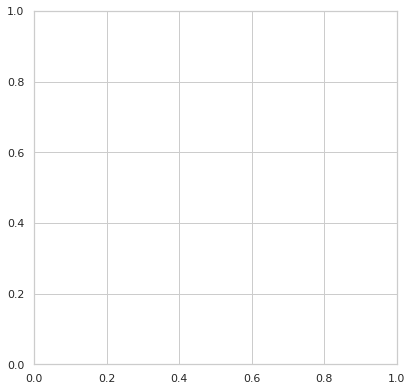

KeyError: 'TMdock-double'

In [53]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["TMdock-double"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["gramm"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (best model))" )
ax.set_xlabel("dockQ Gramm")
ax.set_ylabel("dockQ TMdock")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

KeyError: 'TMdock-double'

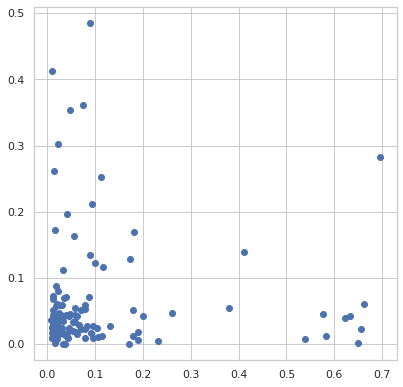

KeyError: 'TMdock-double'

In [54]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["trRosetta","TMdock-double"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["gramm"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        #if (sstr=="3qc8" or sstr=="2hqs" or sstr=="3bs5" ):
        if (sstr=="1ay7" ):
            #if (df_merged.dockQ_y[i]> cutoff and (df_merged.dockQ_y[i]>df_merged.dockQ_x[i])):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (best model)") 
ax.set_xlabel("dockQ Gramm")
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [55]:
df_merged = df_max[df_max["params"].isin(["trRosetta","gramm","TMdock-double"])]
df_merged.sort_values("dockQ")

name  lenA  lenB     msa      msaA      msaB  \
JHparams  code                                                                
trRosetta 4etw  4etw_u2_A-4etw_u1_A   252   252  7563.0  252977.0  252977.0   
          1z5y  1z5y_u2_A-1z5y_u1_A   150   150  2149.0  132152.0  132152.0   
          1yvb  1yvb_u2_A-1yvb_u1_A   237   237   482.0   19991.0   19991.0   
          4pw9  4pw9_u2_A-4pw9_u1_A   366   366  2897.0   42875.0   42875.0   
          4pou  4pou_u2_A-4pou_u1_A   125   125   135.0   44299.0   51048.0   
...                             ...   ...   ...     ...       ...       ...   
gramm     3lb8  3lb8_u1_A-3lb8_u2_A   422   107     0.0       0.0       0.0   
          1nbf  1nbf_u1_A-1nbf_u2_A   340    78     0.0       0.0       0.0   
          1uug  1uug_u1_A-1uug_u2_A   230    83     0.0       0.0       0.0   
          1buh  1buh_u1_A-1buh_u2_A   291    72     0.0       0.0       0.0   
          2hrk  2hrk_u1_A-2hrk_u2_A   181   121     0.0       0.0       0.0   

                cdhit  dockQ   fnat     iRMS  ...  CODE     params      tmAB  \
JHparams  code                                ...                              
trRosetta 4etw   7130  0.000  0.000  439.795  ...  4etw  trRosetta  0.867955   
          1z5y   2113  0.000  0.000  254.762  ...  1z5y  trRosetta  0.830655   
          1yvb    357  0.000  0.000  397.197  ...  1yvb  trRosetta  0.844900   
          4pw9   2392  0.000  0.000  611.834  ...  4pw9  trRosetta  0.766215   
          4pou    108  0.000  0.000  220.541  ...  4pou  trRosetta  0.711820   
...               ...    ...    ...      ...  ...   ...        ...       ...   
gramm     3lb8      0  0.633  0.020   11.792  ...  3lb8      gramm  1.000000   
          1nbf      0  0.649  0.092   20.191  ...  1nbf      gramm  1.000000   
          1uug      0  0.656  0.847    3.542  ...  1uug      gramm  1.000000   
          1buh      0  0.661  0.000   14.865  ...  1buh      gramm  1.000000   
          2hrk      0  0.696  0.978   13.721  ...  2hrk      gramm  1.000000   

                   msaAB  tmAB_max  msaAB_max  tmAB_min  msaAB_min  \
JHparams  code                                                       
trRosetta 4etw  147158.0   0.88718   252977.0   0.84893    41339.0   
          1z5y   67540.0   0.87861   132152.0   0.79121     2928.0   
          1yvb   12997.5   0.86379    19991.0   0.83314     6004.0   
          4pw9   27701.5   0.83664    42875.0   0.70508    12528.0   
          4pou   26168.5   0.79574    51048.0   0.64568     1289.0   
...                  ...       ...        ...       ...        ...   
gramm     3lb8       0.0   1.00000        0.0   1.00000        0.0   
          1nbf       0.0   1.00000        0.0   1.00000        0.0   
          1uug       0.0   1.00000        0.0   1.00000        0.0   
          1buh       0.0   1.00000        0.0   1.00000        0.0   
          2hrk       0.0   1.00000        0.0   1.00000        0.0   

                numcorrect  len  
JHparams  code                   
trRosetta 4etw         0.0  330  
          1z5y         0.0  272  
          1yvb         0.0  346  
          4pw9         0.0  453  
          4pou         0.0  247  
...                    ...  ...  
gramm     3lb8         0.0  529  
          1nbf         0.0  418  
          1uug         0.0  313  
          1buh         0.0  363  
          2hrk         0.0  302  

[321 rows x 54 columns]

In [56]:
len(df_merged.loc[df_merged.dockQ>0.2]["CODE"].unique())

24

In [57]:
len(df_merged.loc[(df_merged.params=="trRosetta")&(df_merged.dockQ>0.2 )]["CODE"].unique())

11

In [58]:
len(df_merged.loc[(df_merged.params=="gramm")&(df_merged.dockQ>0.2 )]["CODE"].unique())

14

In [59]:
len(df_merged.loc[(df_merged.params=="TMdock-double")&(df_merged.dockQ>0.2 )]["CODE"].unique())

0

In [60]:
len(df_merged["CODE"].unique())

205

In [61]:
df.loc[df.params=="TMdock-double"].sort_values("dockQ")

,name,JHparams,lenA,lenB,msa,msaA,msaB,cdhit,dockQ,fnat,...,CODE,params,tmAB,msaAB,tmAB_max,msaAB_max,tmAB_min,msaAB_min,numcorrect,len


In [62]:
df_merged.groupby(["CODE"]).median().sort_values("dockQ")


,lenA,lenB,msa,msaA,msaB,cdhit,dockQ,fnat,iRMS,LRMS,...,hhscore,rank,tmAB,msaAB,tmAB_max,msaAB_max,tmAB_min,msaAB_min,numcorrect,len
CODE,,,,,,,,,,,,,,,,,,,,,
3oed,295.0,295.0,358.0,41324.0,41324.0,261.0,0.0000,0.0000,515.8800,1060.0770,...,0.00,2.0,0.596385,25328.00,0.764650,41324.0,0.439320,9332.0,0.000,426.0
4pw9,366.0,366.0,2897.0,42875.0,42875.0,2392.0,0.0000,0.0000,611.8340,1300.4420,...,0.30,2.0,0.766215,27701.50,0.836640,42875.0,0.705080,12528.0,0.000,453.0
1yvb,237.0,237.0,482.0,19991.0,19991.0,357.0,0.0000,0.0000,397.1970,797.5850,...,11.00,2.0,0.844900,12997.50,0.863790,19991.0,0.833140,6004.0,0.000,346.0
3fap,108.0,108.0,1208.0,34346.0,34346.0,573.0,0.0000,0.0000,183.5570,389.3320,...,0.00,2.0,0.839040,17912.50,0.878230,34346.0,0.799850,1479.0,0.000,201.0
1z5y,150.0,150.0,2149.0,132152.0,132152.0,2113.0,0.0000,0.0000,254.7620,508.1590,...,0.00,2.0,0.830655,67540.00,0.878610,132152.0,0.791210,2928.0,0.000,272.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1uug,230.0,156.5,9.5,3641.0,3631.5,9.5,0.3395,0.4405,11.4670,29.2515,...,9.65,7.5,0.875263,1821.25,0.932875,3641.0,0.818690,1.5,0.000,313.0
1buh,291.0,181.5,588.5,291862.5,277613.0,274.0,0.3610,0.0000,271.4630,559.0795,...,14.30,6.0,0.904012,146390.75,0.920560,291862.5,0.892440,919.0,0.000,363.0
2zae,107.0,107.0,1125.0,1659.0,1659.0,852.0,0.4330,0.3710,3.1870,5.5470,...,0.00,2.0,0.814975,1590.00,0.831220,1659.0,0.798730,1521.0,86.000,200.0


KeyError: 'TMdock-double'

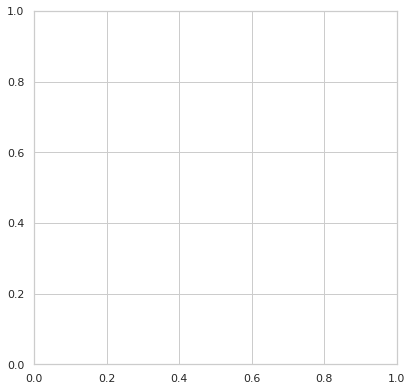

KeyError: 'TMdock-double'

In [63]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["TMdock-double"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_first["gramm"],data_first[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    #cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (first model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ Gramm")
ax.set_ylabel("dockQ TMdock")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

KeyError: 'TMdock-nohomology'

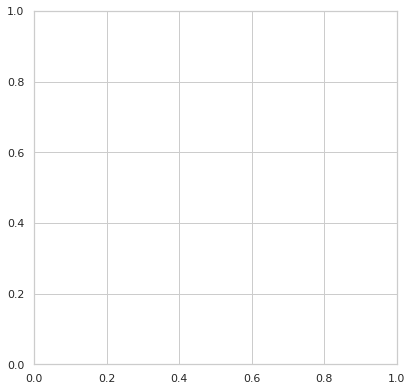

KeyError: 'TMdock-nohomology'

In [64]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["TMdock-double"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["TMdock-nohomology"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ TMdock-nohomology")
ax.set_ylabel("dockQ TMdock "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

KeyError: 'TMdock'

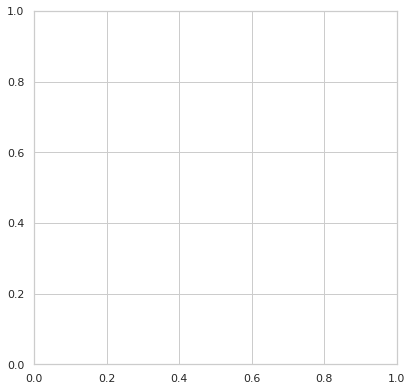

KeyError: 'TMdock'

In [65]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["trRosetta"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["TMdock"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (best model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ TMdock")
ax.set_ylabel("dockQ TMdock "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

KeyError: 'pdbcontacts-new'

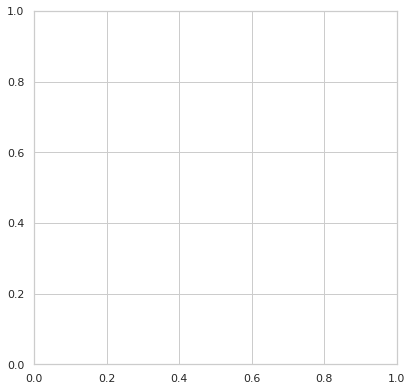

KeyError: 'pdbcontacts-new'

In [66]:
cutoff=1.0
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("^PDB|^pdb")
pdbset=list(filter(r.match, datasets))
pdbset=["pdbconfold"]

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts-new":continue
    df_merged = pd.merge(data_max["pdbcontacts-new"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)
plt.savefig("pdbconfold.png")
#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

No handles with labels found to put in legend.


Text(0, 0.5, 'dockQ  pdbconfold')

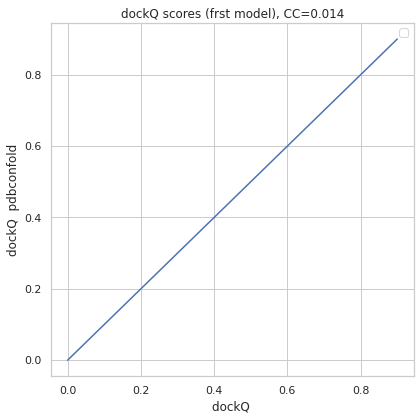

In [67]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile(".*step1.*")
pdbset=list(filter(r.match, datasets))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

KeyError: 'pdbcontacts'

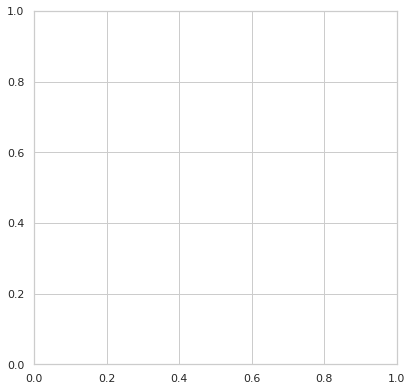

KeyError: 'pdbcontacts'

In [68]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("pdbconfold")
pdbset=list(filter(r.match, datasets))
pdbset=["PDB"]

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        #if (df_merged.dockQ_y[i]- df_merged.dockQ_x[i]>cutoff):
        #    ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ pdbcontacts")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

KeyError: 'PDB'

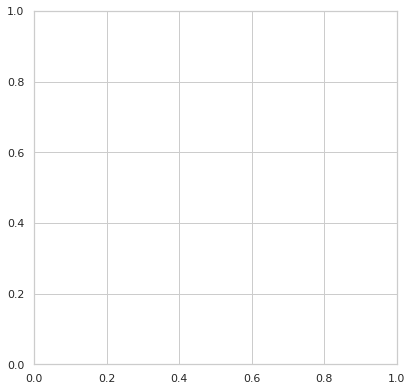

KeyError: 'PDB'

In [69]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("pdbconfold")
pdbset=list(filter(r.match, datasets))
pdbset=["pdbconfold"]

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["PDB"],data_max[d], on=['code'],how="outer")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        #if (df_merged.dockQ_y[i]- df_merged.dockQ_x[i]>cutoff):
        #    ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ PDB")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

No handles with labels found to put in legend.


Text(0, 0.5, 'dockQ  pdbconfold')

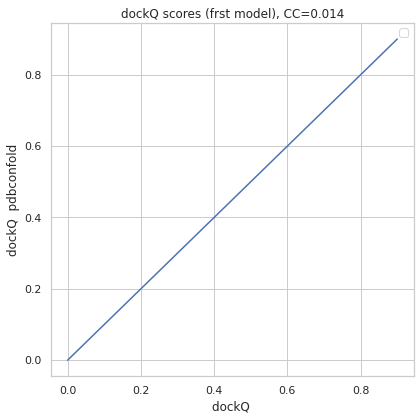

In [70]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("^PDBNEWDOCK-[ABCD]$")
pdbset=list(filter(r.match, datasets))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

No handles with labels found to put in legend.


Text(0, 0.5, 'dockQ  pdbconfold')

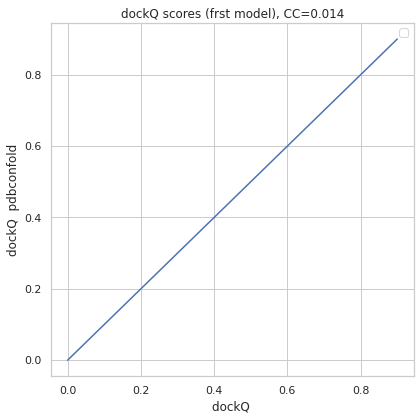

In [71]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile(".*dockB-relax.*")
pdbset=list(filter(r.match, datasets))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

No handles with labels found to put in legend.


Text(0, 0.5, 'dockQ  pdbconfold')

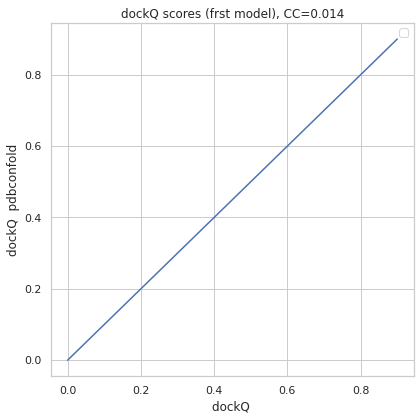

In [72]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile(".*dockC-relax.*")
pdbset=list(filter(r.match, datasets))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

No handles with labels found to put in legend.


Text(0, 0.5, 'dockQ  pdbconfold')

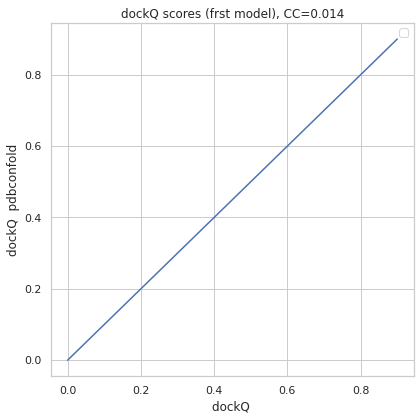

In [73]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile(".*dockD-relax.*")
pdbset=list(filter(r.match, datasets))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

KeyError: 'pdbcontacts'

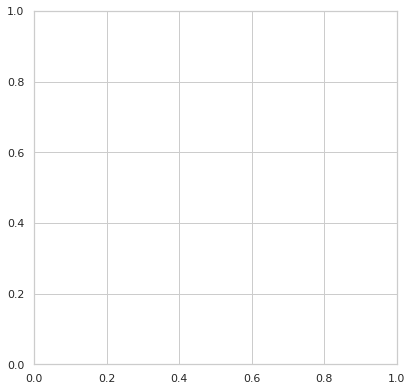

KeyError: 'pdbcontacts'

In [74]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("^PDBNEWDOCK-C.*-relax.*")
pdbset=list(filter(r.match, datasets))+["PDBNEWDOCK-C"]

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["pdbcontacts"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

KeyError: 'pdbcontacts-new'

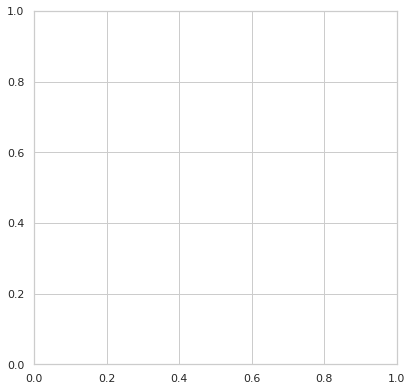

KeyError: 'pdbcontacts-new'

In [75]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("^PDBNEWDOCK-C.*-relax.*")
pdbset=list(filter(r.match, datasets))+["PDBNEWDOCK-C"]
pdbset=["PDBNEWDOCK-B","PDBNEWDOCK-C","PDBNEWDOCK-A--dockC-relax",
        "PDBNEWDOCK-C--dockC-relax","PDBNEWDOCK-B--dockD-relax",
        "PDBNEWDOCK-C--dockD-relax"]

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts-new":continue
    df_merged = pd.merge(data_max["pdbcontacts-new"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

KeyError: 'PDB'

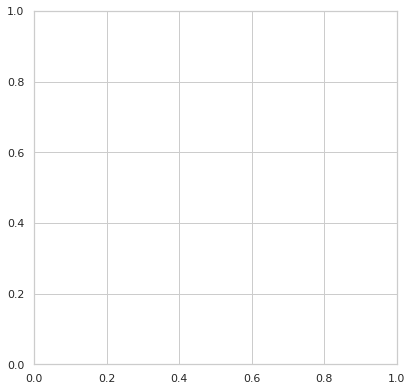

KeyError: 'PDB'

In [76]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("^PDBNEWDOCK-C.*-relax.*")
pdbset=list(filter(r.match, datasets))+["PDBNEWDOCK-C"]
pdbset=["pdbcontacts","pdbnewcontacts","PDBNEWDOCK-standard","PDBNEWDOCK-repulsion","pdbconfold"]

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    #if d=="pdbcontacts":continue
    df_merged = pd.merge(data_max["PDB"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [77]:
r=re.compile(".*relax.*")
#pdbset=list(filter(r.match, datasets))+['PDBNEWDOCK-A','PDBNEWDOCK-B', 'PDBNEWDOCK-C', 'PDBNEWDOCK-D',"pdbcontacts"]
pdbset=sorted(["PDB","PDBNEWDOCK-B","PDBNEWDOCK-C","PDBNEWDOCK-A--dockC-relax",
        "PDBNEWDOCK-C--dockC-relax","PDBNEWDOCK-B--dockD-relax",
        "PDBNEWDOCK-C--dockD-relax","pdbcontacts","pdbnewcontacts","PDBNEWDOCK-standard",
               "PDBNEWDOCK-repulsion","pdbconfold"])


smallset=["1ay7", "1b27", "1bvn", "1gcq", "1gpw", "1he1", "1i4e", "1i8l",
"1jiw", "1k5g", "1nql", "1vg0", "2aq3", "2b4s", "2d5r", "2grx",
"2hj9", "2hrk", "2ido", "2nqd", "2nxn", "2o3b", "2sge", "2wbw",
"2x9a", "2xwb", "2zae", "3a1p", "3a8i", "3bs5", "3buz", "3cw2",
"3cw2", "3fpu", "3lwn", "3ona", "3rnk", "3vlb", "3w31", "3wkt",
"4bi8", "4bmp", "4gmj", "4hcn", "4k0v", "4kyi", "4o4b", "4rf0",
"4xhu", "4yoc"]
codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
codes=smallset
codes=df_max.loc[(df_max.params=="PDBNEWDOCK-A--dockC-relax")&(df_max.params.isin(pdbset) )]["CODE"].unique()
codes=df_max.loc[(df_max.params=="PDBNEWDOCK-C")&(df_max.params.isin(pdbset) )]["CODE"].unique()

codes=smallset

In [78]:
cutoff=0.2
newdf=df_max.loc[df_max.dockQ>cutoff]
newdf=newdf.reset_index()

PDB
PDBNEWDOCK-A--dockC-relax
PDBNEWDOCK-B
PDBNEWDOCK-B--dockD-relax
PDBNEWDOCK-C
PDBNEWDOCK-C--dockC-relax
PDBNEWDOCK-C--dockD-relax
PDBNEWDOCK-repulsion
PDBNEWDOCK-standard
pdbconfold
pdbcontacts
pdbnewcontacts


ValueError: zero-size array to reduction operation minimum which has no identity

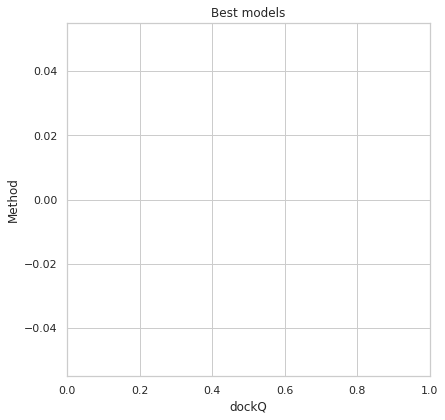

ValueError: zero-size array to reduction operation minimum which has no identity

In [79]:
# FInd best method for each model.
#codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=newdf.loc[newdf.JHparams.isin(pdbset)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(pdbset))].reset_index()
#plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
#plt.scatter(best_df.dockQ,best_df.JHparams,color="red")


all_df=df_max.loc[(df_max.CODE.isin(codes))&(df_max.params.isin(pdbset))].reset_index()
plt.scatter(all_df.dockQ,all_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(pdbset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    i+=1
    print (d)
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(all_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    #numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[all_df.JHparams[i]]==0:
        done[all_df.JHparams[i]]=1
        #ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[all_df.JHparams[i]],3))+"("+str(length[all_df.JHparams[i]])+")"
                    ,(1.0, all_df.JHparams[i]))


In [80]:
datasets

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged',
       'N1-N3-merged-fast', 'N1-N3-new', 'N1-N3-multimerged',
       '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged', 'N1-top1000',
       'N1-top100', 'N1-top2000', 'N1-top500', 'N3dock',
       '-N 3 --incE 1.e-2', 'N3-merged', 'N3-multimerged', 'N3-newdockA',
       'N3-newdockB', 'N3-newdockC', 'N5-newdockA', 'trRosetta',
       'JHranked'], dtype=object)

In [81]:
pdbset=[ 'N3dock',
       'N3-newdockA', 'N3-newdockB', 'N3-newdockC', 'N5-newdockA','N5-newdockB',
       'N5-newdockC', '-N 5 --cpu 8',"-N 3 --cpu 8"]
codes=df_max.loc[(df_max.params=="N3-newdockC")&(df_max.params.isin(pdbset) )]["CODE"].unique()
codes

array(['1b27', '1bvn', '1gcq', '1gpw', '1i4e', '1i8l', '1jiw', '1k5g',
       '1nql', '1vg0', '2aq3', '2b4s', '2d5r', '2hj9', '2hrk', '2nqd',
       '2o3b', '2sge', '2wbw', '3a1p', '3a8i', '3bs5', '3cw2', '3fpu',
       '3rnk', '3w31', '4bi8', '4bmp', '4gmj', '4hcn', '4xhu'],
      dtype=object)

KeyError: 'N5-newdockB'

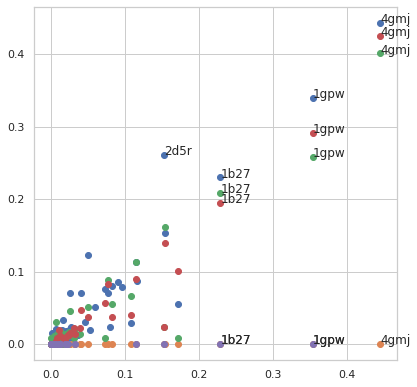

KeyError: 'N5-newdockB'

In [82]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="-N 3 --cpu 8":continue
    df_merged = pd.merge(data_max["-N 3 --cpu 8"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

-N 3 --cpu 8 31
-N 5 --cpu 8 0
N3-newdockA 30
N3-newdockB 30
N3-newdockC 31
N3dock 25
N5-newdockA 14
N5-newdockB 0
N5-newdockC 0


IndexError: index out of bounds

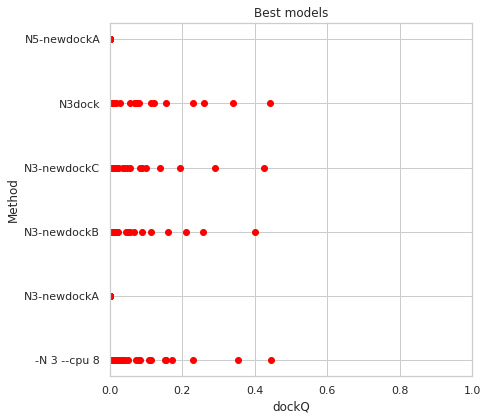

IndexError: index out of bounds

In [83]:
# FInd best method for each model.
#codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=newdf.loc[newdf.JHparams.isin(pdbset)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(pdbset))].reset_index()
#plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
#plt.scatter(best_df.dockQ,best_df.JHparams,color="red")


all_df=df_max.loc[(df_max.CODE.isin(codes))&(df_max.params.isin(pdbset))].reset_index()
plt.scatter(all_df.dockQ,all_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(pdbset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    print (d,len(data[i]))
    i+=1
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(all_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    #numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[all_df.JHparams[i]]==0:
        done[all_df.JHparams[i]]=1
        #ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[all_df.JHparams[i]],3))+"("+str(length[all_df.JHparams[i]])+")"
                    ,(1.0, all_df.JHparams[i]))


In [84]:
pdbset=sorted(["N1","N3"])

In [85]:
for d in pdbset:
    print (d,len(df_max.loc[(df_max.params==d)]["CODE"].unique()))

N1 0
N3 0


In [86]:
all_df

,JHparams,code,name,lenA,lenB,msa,msaA,msaB,cdhit,dockQ,...,CODE,params,tmAB,msaAB,tmAB_max,msaAB_max,tmAB_min,msaAB_min,numcorrect,len
0,-N 3 --cpu 8,1b27,1b27_u2_A-1b27_u1_A,109,109,733.0,2034.0,2034.0,656,0.229,...,1b27,-N 3 --cpu 8,0.824750,1759.0,0.85428,2034.0,0.79522,1484.0,49.025,199
1,-N 3 --cpu 8,1bvn,1bvn_u2_A-1bvn_u1_A,496,496,95.0,52623.0,52623.0,85,0.013,...,1bvn,-N 3 --cpu 8,0.619740,26373.0,0.70905,52623.0,0.53043,123.0,0.000,571
2,-N 3 --cpu 8,1gcq,1gcq_u2_A-1gcq_u1_A,66,66,1365.0,77704.0,77704.0,771,0.115,...,1gcq,-N 3 --cpu 8,0.555390,77600.5,0.63426,77704.0,0.52080,77497.0,71.760,123
3,-N 3 --cpu 8,1gpw,1gpw_u2_A-1gpw_u1_A,252,252,7137.0,67629.0,67629.0,5348,0.354,...,1gpw,-N 3 --cpu 8,0.889770,63047.5,0.89718,67629.0,0.88236,58466.0,130.000,456
4,-N 3 --cpu 8,1i4e,1i4e_u2_A-1i4e_u1_A,296,296,1.0,15596.0,15596.0,1,0.013,...,1i4e,-N 3 --cpu 8,0.263340,7803.5,0.26537,15596.0,0.26131,11.0,0.000,537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,N5-newdockA,1vg0,1vg0_u1_A-1vg0_u2_A,495,185,166.0,181474.0,323282.0,104,0.000,...,1vg0,N5-newdockA,0.514665,252378.0,0.62476,323282.0,0.40457,181474.0,0.000,680
157,N5-newdockA,2aq3,2aq3_u1_A-2aq3_u2_A,239,111,1.0,60.0,233507.0,1,0.000,...,2aq3,N5-newdockA,0.274630,116783.5,0.28943,233507.0,0.25983,60.0,0.000,350
158,N5-newdockA,2b4s,2b4s_u1_A-2b4s_u2_A,298,298,1128.0,560200.0,38771.0,769,0.000,...,2b4s,N5-newdockA,0.763125,299485.5,0.76682,560200.0,0.75943,38771.0,0.000,596
159,N5-newdockA,2d5r,2d5r_u2_A-2d5r_u1_A,265,265,521.0,6345.0,6345.0,226,0.000,...,2d5r,N5-newdockA,0.788660,4065.0,0.87487,6345.0,0.70245,1785.0,17.996,386


In [87]:
cutoff=0.2
newdf=df_max.loc[df_max.dockQ>cutoff]
newdf=newdf.reset_index()


In [88]:
datasets

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged',
       'N1-N3-merged-fast', 'N1-N3-new', 'N1-N3-multimerged',
       '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged', 'N1-top1000',
       'N1-top100', 'N1-top2000', 'N1-top500', 'N3dock',
       '-N 3 --incE 1.e-2', 'N3-merged', 'N3-multimerged', 'N3-newdockA',
       'N3-newdockB', 'N3-newdockC', 'N5-newdockA', 'trRosetta',
       'JHranked'], dtype=object)

In [89]:
r=re.compile(".*relax.*")
pdbset=list(filter(r.match, datasets))+['PDBNEWDOCK-A','PDBNEWDOCK-B', 'PDBNEWDOCK-C', 'PDBNEWDOCK-D',"pdbcontacts","pdbconfold","PDB"]


smallset=["1ay7", "1b27", "1bvn", "1gcq", "1gpw", "1he1", "1i4e", "1i8l",
"1jiw", "1k5g", "1nql", "1vg0", "2aq3", "2b4s", "2d5r", "2grx",
"2hj9", "2hrk", "2ido", "2nqd", "2nxn", "2o3b", "2sge", "2wbw",
"2x9a", "2xwb", "2zae", "3a1p", "3a8i", "3bs5", "3buz", "3cw2",
"3cw2", "3fpu", "3lwn", "3ona", "3rnk", "3vlb", "3w31", "3wkt",
"4bi8", "4bmp", "4gmj", "4hcn", "4k0v", "4kyi", "4o4b", "4rf0",
"4xhu", "4yoc"]
codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
codes=smallset
codes=df_max.loc[(df_max.params=="PDBNEWDOCK-A")&(df_max.params.isin(pdbset) )]["CODE"].unique()


ValueError: zero-size array to reduction operation minimum which has no identity

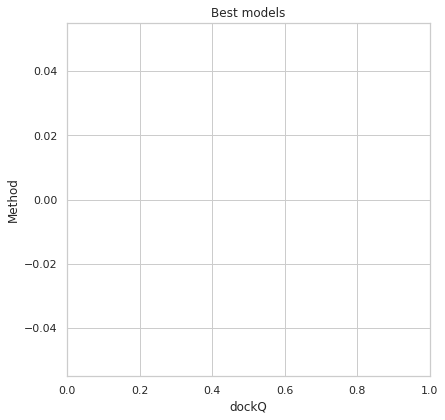

ValueError: zero-size array to reduction operation minimum which has no identity

In [90]:
# FInd best method for each model.
#codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=newdf.loc[newdf.JHparams.isin(pdbset)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(pdbset))].reset_index()
#plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
#plt.scatter(best_df.dockQ,best_df.JHparams,color="red")


all_df=df_max.loc[(df_max.CODE.isin(codes))&(df_max.params.isin(pdbset))].reset_index()
plt.scatter(all_df.dockQ,all_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(pdbset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    i+=1
    #print (d)
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(all_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    #numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[all_df.JHparams[i]]==0:
        done[all_df.JHparams[i]]=1
        #ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[all_df.JHparams[i]],3))+"("+str(length[all_df.JHparams[i]])+")"
                    ,(1.0, all_df.JHparams[i]))


In [91]:
codes

array([], dtype=object)

In [92]:
all_df

,JHparams,code,name,lenA,lenB,msa,msaA,msaB,cdhit,dockQ,...,CODE,params,tmAB,msaAB,tmAB_max,msaAB_max,tmAB_min,msaAB_min,numcorrect,len


ValueError: zero-size array to reduction operation minimum which has no identity

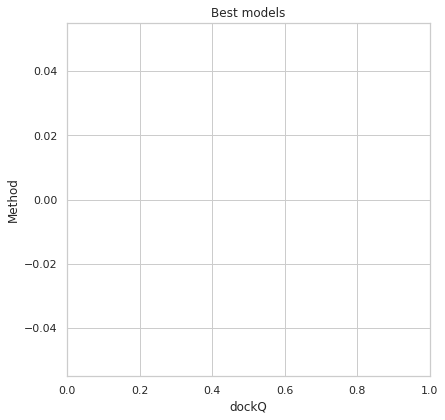

ValueError: zero-size array to reduction operation minimum which has no identity

In [93]:
# FInd best method for each model.
codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=newdf.loc[newdf.JHparams.isin(pdbset)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(pdbset))].reset_index()
plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
plt.scatter(best_df.dockQ,best_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(pdbset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    i+=1
    #print (d)
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(best_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[best_df.JHparams[i]]==0:
        done[best_df.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[best_df.JHparams[i]],3))+"("+str(length[good_df.JHparams[i]])+")"
                    ,(1.0, best_df.JHparams[i]))
for d in datasets:
    done[d]=0
for i, txt in enumerate(good_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(good_df.loc[good_df.JHparams==good_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[good_df.JHparams[i]]==0:
        done[good_df.JHparams[i]]=1
        ax.annotate(str(numhit),(.1, good_df.JHparams[i]))
        #ax.annotate(str(round(average[good_df.JHparams[i]],3)),(1.0, good_df.JHparams[i]))
        #ax.annotate("("+str(length[good_df.JHparams[i]])+")",(1.2, good_df.JHparams[i]))


IndexError: index out of bounds

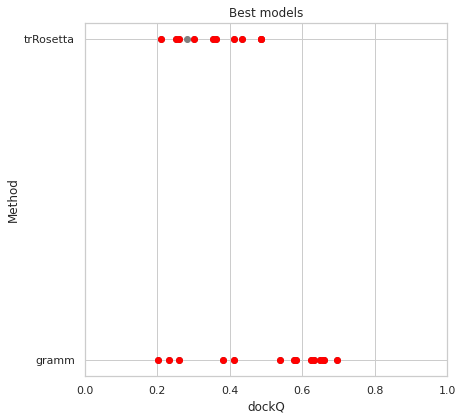

IndexError: index out of bounds

In [94]:
compareset=["trRosetta","gramm","TMdock-double"]
codes=df_max.loc[df_max.params.isin(compareset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=newdf.loc[newdf.JHparams.isin(compareset)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(compareset))].reset_index()
plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
plt.scatter(best_df.dockQ,best_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(compareset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    i+=1
    #print (d)
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(best_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[best_df.JHparams[i]]==0:
        done[best_df.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        #ax.annotate(str(round(average[best_df.JHparams[i]],3))+
        #            "("+str(length[good_df.JHparams[i]])+")"
        #            ,(1.0, best_df.JHparams[i]))
for d in datasets:
    done[d]=0
for i, txt in enumerate(good_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(good_df.loc[good_df.JHparams==good_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[good_df.JHparams[i]]==0:
        done[good_df.JHparams[i]]=1
        #ax.annotate(str(numhit),(.1, good_df.JHparams[i]))
        #ax.annotate(str(round(average[good_df.JHparams[i]],3)),(1.0, good_df.JHparams[i]))
        #ax.annotate("("+str(length[good_df.JHparams[i]])+")",(1.2, good_df.JHparams[i]))


In [95]:
best_df

,index,JHparams,code,name,lenA,lenB,msa,msaA,msaB,cdhit,...,CODE,params,tmAB,msaAB,tmAB_max,msaAB_max,tmAB_min,msaAB_min,numcorrect,len
0,77,gramm,2hrk,2hrk_u1_A-2hrk_u2_A,181,121,0.0,0.0,0.0,0,...,2hrk,gramm,1.000000,0.0,1.00000,0.0,1.00000,0.0,0.000,302
1,71,gramm,1buh,1buh_u1_A-1buh_u2_A,291,72,0.0,0.0,0.0,0,...,1buh,gramm,1.000000,0.0,1.00000,0.0,1.00000,0.0,0.000,363
2,73,gramm,1uug,1uug_u1_A-1uug_u2_A,230,83,0.0,0.0,0.0,0,...,1uug,gramm,1.000000,0.0,1.00000,0.0,1.00000,0.0,0.000,313
3,72,gramm,1nbf,1nbf_u1_A-1nbf_u2_A,340,78,0.0,0.0,0.0,0,...,1nbf,gramm,1.000000,0.0,1.00000,0.0,1.00000,0.0,0.000,418
4,79,gramm,3lb8,3lb8_u1_A-3lb8_u2_A,422,107,0.0,0.0,0.0,0,...,3lb8,gramm,1.000000,0.0,1.00000,0.0,1.00000,0.0,0.000,529
5,82,gramm,3vlb,3vlb_u1_A-3vlb_u2_A,413,222,0.0,0.0,0.0,0,...,3vlb,gramm,1.000000,0.0,1.00000,0.0,1.00000,0.0,0.000,635
6,81,gramm,3prp,3prp_u1_A-3prp_u2_A,184,77,0.0,0.0,0.0,0,...,3prp,gramm,1.000000,0.0,1.00000,0.0,1.00000,0.0,0.000,261
7,75,gramm,1zlh,1zlh_u1_A-1zlh_u2_A,306,76,0.0,0.0,0.0,0,...,1zlh,gramm,1.000000,0.0,1.00000,0.0,1.00000,0.0,0.000,382
8,74,gramm,1wq1,1wq1_u1_A-1wq1_u2_A,325,167,0.0,0.0,0.0,0,...,1wq1,gramm,1.000000,0.0,1.00000,0.0,1.00000,0.0,0.000,492
9,92,trRosetta,2hqs,2hqs_u2_A-2hqs_u1_A,398,398,2536.0,591389.0,376708.0,2201,...,2hqs,trRosetta,0.902625,311983.5,0.92213,591389.0,0.88634,32693.0,100.035,507


In [96]:
codes

array(['1b27', '1buh', '1g6v', '1gcq', '1gg2', '1gpw', '1i4e', '1i8l',
       '1jiw', '1jk9', '1kgy', '1lb2', '1nbf', '1nql', '1nw9', '1qav',
       '1r8s', '1s1q', '1tmq', '1uug', '1vrs', '1wq1', '1wrd', '1y64',
       '1y8x', '1zlh', '2a41', '2aq3', '2b4s', '2bcg', '2bcn', '2c2v',
       '2ch4', '2d5r', '2grx', '2gwf', '2hj9', '2hrk', '2i25', '2o25',
       '2o2v', '2o3b', '2o8v', '2qyi', '2uy7', '2v55', '2vrr', '2wbw',
       '2xgy', '2xwb', '3a1p', '3a8i', '3av0', '3bh6', '3bs5', '3buz',
       '3cu1', '3cw2', '3d3c', '3e2l', '3f1p', '3f7p', '3fn1', '3fpu',
       '3k1i', '3l4q', '3lb8', '3mj7', '3ong', '3oun', '3prp', '3pv6',
       '3qlu', '3rnk', '3t5g', '3tg1', '3vlb', '3w31', '3wkt', '3znz',
       '4bbn', '4bi8', '4bmp', '4bos', '4boz', '4c6t', '4ct4', '4fme',
       '4ged', '4gmj', '4goj', '4ilh', '4j38', '4jx1', '4kyi', '4lsx',
       '4lx0', '4m3k', '4mdk', '4mrt', '4n6o', '4o4b', '4p2a', '4p4q',
       '4pou', '4rix', '4txo', '4txv', '4x6q', '4xhu', '4xoi', '4xs0',
      

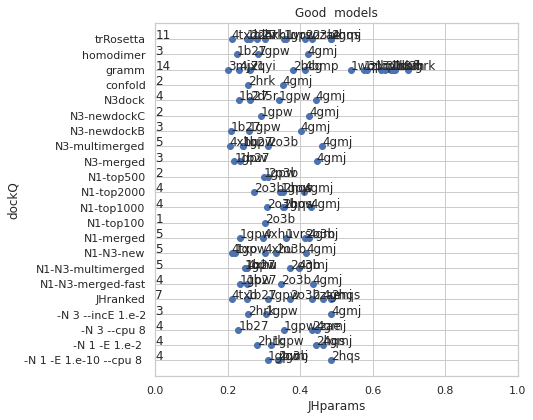

In [97]:

f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(newdf.dockQ,newdf.JHparams)
#cc=np.corrcoef(newdf.dockQ,newdf.len)
ax.set_title("Good  models")
ax.set_xlabel("JHparams")
ax.set_ylabel("dockQ")
ax.set(xlim=[0,1])
done={}
for d in datasets:
    done[d]=0
for i, txt in enumerate(newdf.name):
    #print (i,txt)
    sstr=txt[0:4]
    ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(newdf.loc[newdf.JHparams==newdf.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[newdf.JHparams[i]]==0:
        done[newdf.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, newdf.JHparams[i]))

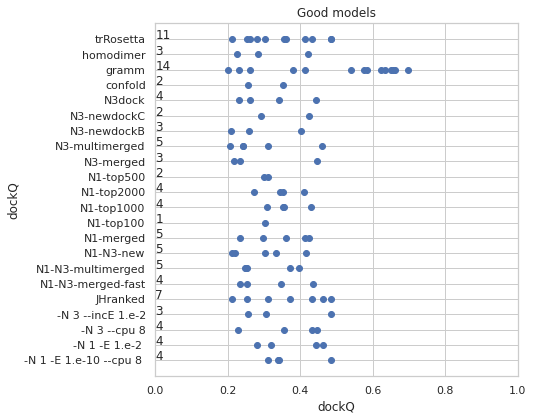

In [98]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(newdf.dockQ,newdf.JHparams)
#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Good models")
ax.set_xlabel("dockQ")
ax.set_ylabel("dockQ")
ax.set(xlim=[0,1])
done={}
for d in datasets:
    done[d]=0
for i, txt in enumerate(newdf.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(newdf.loc[newdf.JHparams==newdf.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[newdf.JHparams[i]]==0:
        done[newdf.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, newdf.JHparams[i]))

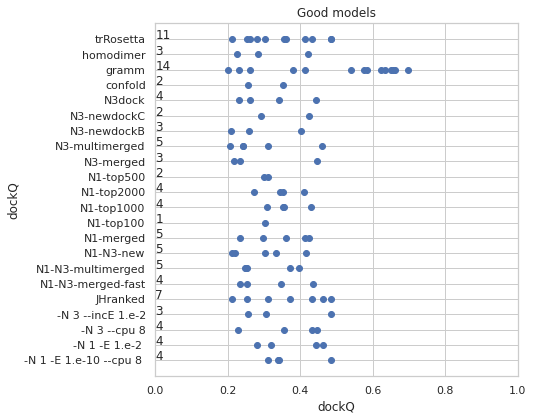

In [99]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(newdf.dockQ,newdf.JHparams)
#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Good models")
ax.set_xlabel("dockQ")
ax.set_ylabel("dockQ")
ax.set(xlim=[0,1])
done={}
for d in datasets:
    done[d]=0
for i, txt in enumerate(newdf.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(newdf.loc[newdf.JHparams==newdf.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[newdf.JHparams[i]]==0:
        done[newdf.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, newdf.JHparams[i]))

In [100]:
datasets

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged',
       'N1-N3-merged-fast', 'N1-N3-new', 'N1-N3-multimerged',
       '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged', 'N1-top1000',
       'N1-top100', 'N1-top2000', 'N1-top500', 'N3dock',
       '-N 3 --incE 1.e-2', 'N3-merged', 'N3-multimerged', 'N3-newdockA',
       'N3-newdockB', 'N3-newdockC', 'N5-newdockA', 'trRosetta',
       'JHranked'], dtype=object)

In [101]:
# here we find what method is best for each target

r = re.compile("^PDB.*|^TMd.*|^gramm|trRosetta|^pdb.*")
excludecolumns = list(filter(r.match, datasets)) # Read Note
print(excludecolumns)
excludecolumns+=["confold","rbh-merged-pdb"]
tempdf=newdf.loc[~newdf.JHparams.isin(excludecolumns)]

#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['code']).reset_index()
best_df.sort_values("JHparams")

['gramm', 'trRosetta']


,index,JHparams,code,name,lenA,lenB,msa,msaA,msaB,cdhit,...,CODE,params,tmAB,msaAB,tmAB_max,msaAB_max,tmAB_min,msaAB_min,numcorrect,len
7,6,-N 1 -E 1.e-2,2hrk,2hrk_u1_A-2hrk_u2_A,181,121,59.0,397.0,64.0,56,...,2hrk,-N 1 -E 1.e-2,0.677510,230.5,0.70198,397.0,0.65304,64.0,1.972,302
5,9,-N 3 --cpu 8,1gpw,1gpw_u2_A-1gpw_u1_A,252,252,7137.0,67629.0,67629.0,5348,...,1gpw,-N 3 --cpu 8,0.889770,63047.5,0.89718,67629.0,0.88236,58466.0,130.000,456
1,14,-N 3 --incE 1.e-2,4gmj,4gmj_u1_A-4gmj_u2_A,253,236,1189.0,6237.0,1654.0,514,...,4gmj,-N 3 --incE 1.e-2,0.835100,3945.5,0.86274,6237.0,0.80746,1654.0,132.090,489
0,17,JHranked,2hqs,2hqs_u2_A-2hqs_u1_A,398,398,2396.0,15892.0,13281.0,2017,...,2hqs,JHranked,0.902625,14586.5,0.92098,15892.0,0.88634,13281.0,100.035,507
2,19,JHranked,2zae,2zae_u2_A-2zae_u1_A,107,107,1125.0,1659.0,1659.0,852,...,2zae,JHranked,0.814975,1590.0,0.83122,1659.0,0.79873,1521.0,86.000,200
9,15,JHranked,1b27,1b27_u2_A-1b27_u1_A,109,109,733.0,2034.0,2034.0,656,...,1b27,JHranked,0.811355,1759.0,0.85249,2034.0,0.77022,1484.0,49.025,199
10,21,JHranked,4txo,4txo_u2_A-4txo_u1_A,178,178,7106.0,120547.0,120547.0,6529,...,4txo,JHranked,0.797345,87307.5,0.79905,120547.0,0.79564,54068.0,1.000,336
6,35,N1-N3-new,4xhu,4xhu_u2_A-4xhu_u1_A,352,352,410.0,8381.0,8381.0,240,...,4xhu,N1-N3-new,0.827330,4344.0,0.85317,8381.0,0.80149,307.0,0.000,447
3,38,N1-merged,2o3b,2o3b_u2_A-2o3b_u1_A,240,240,456.0,5431.0,5431.0,301,...,2o3b,N1-merged,0.727490,2974.5,0.83406,5431.0,0.62495,518.0,29.008,384
4,37,N1-merged,1vrs,1vrs_u1_A-1vrs_u2_A,124,117,14.0,100319.0,2803.0,14,...,1vrs,N1-merged,0.822955,51561.0,0.83610,100319.0,0.80981,2803.0,53.988,241


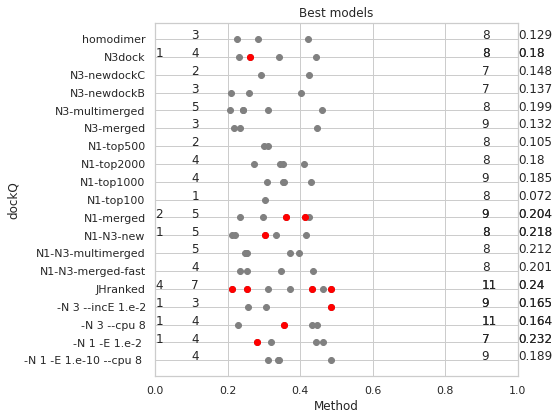

In [102]:
# FInd best method for each model.
codes=best_df["code"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
good_df=newdf.loc[(newdf.code.isin(codes))&(~newdf.JHparams.isin(excludecolumns))].reset_index()
plt.scatter(good_df.dockQ,good_df.JHparams,color="grey")
plt.scatter(best_df.dockQ,best_df.JHparams,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_xlabel("Method")
ax.set_ylabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
for d in datasets:
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
for i, txt in enumerate(best_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(best_df.loc[best_df.JHparams==best_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[best_df.JHparams[i]]==0:
        done[best_df.JHparams[i]]=1
        ax.annotate(str(numhit),(.0, best_df.JHparams[i]))
        ax.annotate(str(round(average[best_df.JHparams[i]],3)),(1.0, best_df.JHparams[i]))
        ax.annotate(str(length[best_df.JHparams[i]]),(.9, best_df.JHparams[i]))
for d in datasets:
    done[d]=0
for i, txt in enumerate(good_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(good_df.loc[good_df.JHparams==good_df.JHparams[i]])
    #print (numhit,newdf.JHparams[i])
    if done[good_df.JHparams[i]]==0:
        done[good_df.JHparams[i]]=1
        ax.annotate(str(numhit),(.1, good_df.JHparams[i]))
        ax.annotate(str(round(average[good_df.JHparams[i]],3)),(1.0, good_df.JHparams[i]))
        ax.annotate(str(length[good_df.JHparams[i]]),(.9, good_df.JHparams[i]))


In [103]:
df.sort_values('dockQ', ascending=False).drop_duplicates(["code"])

,name,JHparams,lenA,lenB,msa,msaA,msaB,cdhit,dockQ,fnat,...,CODE,params,tmAB,msaAB,tmAB_max,msaAB_max,tmAB_min,msaAB_min,numcorrect,len
1019,2hrk_u1_A-2hrk_u2_A,gramm,181,121,0,0,0,0,0.696,0.978,...,2hrk,gramm,1.000000,0.0,1.00000,0.0,1.00000,0.0,0,302
659,1buh_u1_A-1buh_u2_A,gramm,291,72,0,0,0,0,0.661,0,...,1buh,gramm,1.000000,0.0,1.00000,0.0,1.00000,0.0,0,363
836,1uug_u1_A-1uug_u2_A,gramm,230,83,0,0,0,0,0.656,0.797,...,1uug,gramm,1.000000,0.0,1.00000,0.0,1.00000,0.0,0,313
766,1nbf_u1_A-1nbf_u2_A,gramm,340,78,0,0,0,0,0.649,0,...,1nbf,gramm,1.000000,0.0,1.00000,0.0,1.00000,0.0,0,418
1312,3lb8_u1_A-3lb8_u2_A,gramm,422,107,0,0,0,0,0.633,0,...,3lb8,gramm,1.000000,0.0,1.00000,0.0,1.00000,0.0,0,529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3864,3oed_u1_A-3oed_u2_A,trRosetta,295,131,358,9332,41324,255,0,0,...,3oed,trRosetta,0.595360,25328.0,0.76465,41324.0,0.42607,9332.0,0,426
3882,3qc8_u1_A-3qc8_u2_A,trRosetta,169,82,1288,5761,8453,501,0,0,...,3qc8,trRosetta,0.698285,7107.0,0.84258,8453.0,0.55399,5761.0,0,251
3886,3rj3_u1_A-3rj3_u2_A,trRosetta,295,126,353,9332,54903,241,0,0,...,3rj3,trRosetta,0.621845,32117.5,0.75942,54903.0,0.48427,9332.0,0,421
3926,4etw_u1_A-4etw_u2_A,trRosetta,252,78,7563,252977,41339,7130,0,0,...,4etw,trRosetta,0.867955,147158.0,0.88718,252977.0,0.84873,41339.0,0,330


In [104]:
df.loc[(df.dockQ>cutoff) & (~df.JHparams.isin(excludecolumns))].groupby("name").max()


,JHparams,lenA,lenB,msa,msaA,msaB,cdhit,dockQ,fnat,iRMS,...,CODE,params,tmAB,msaAB,tmAB_max,msaAB_max,tmAB_min,msaAB_min,numcorrect,len
name,,,,,,,,,,,,,,,,,,,,,
1b27_u1_A-1b27_u2_A,homodimer,109,90,733.0,1484.0,2034.0,654,0.242,0.160,4.984,...,1b27,homodimer,0.825820,1759.0,0.85658,2034.0,0.79706,1484.0,49.025,199
1b27_u2_A-1b27_u1_A,homodimer,90,109,733.0,2034.0,1484.0,656,0.252,0.200,5.319,...,1b27,homodimer,0.810645,1759.0,0.85149,2034.0,0.78685,1484.0,46.020,199
1gpw_u1_A-1gpw_u2_A,N3dock,252,204,7146.0,80768.0,76000.0,5374,0.351,0.293,5.201,...,1gpw,N3dock,0.887350,78384.0,0.89390,80768.0,0.88442,76000.0,169.000,456
1gpw_u2_A-1gpw_u1_A,homodimer,204,252,7137.0,67629.0,58466.0,5343,0.354,0.293,5.614,...,1gpw,homodimer,0.889770,63047.5,0.89745,67629.0,0.88236,58466.0,130.000,456
1vrs_u1_A-1vrs_u2_A,N1-merged,124,117,14.0,100319.0,2803.0,14,0.361,0.449,2.953,...,1vrs,N1-merged,0.822955,51561.0,0.83610,100319.0,0.80981,2803.0,53.988,241
2d5r_u2_A-2d5r_u1_A,N3dock,121,265,521.0,1771.0,6154.0,225,0.261,0.203,10.074,...,2d5r,N3dock,0.752890,3962.5,0.87927,6154.0,0.62651,1771.0,17.996,386
2hqs_u1_A-2hqs_u2_A,N1-top2000,398,109,2396.0,13281.0,15892.0,2014,0.486,0.434,2.896,...,2hqs,N1-top2000,0.902625,14586.5,0.92213,15892.0,0.88427,13281.0,100.035,507
2hqs_u2_A-2hqs_u1_A,JHranked,109,398,2396.0,15892.0,13281.0,2017,0.444,0.329,2.474,...,2hqs,JHranked,0.901260,14586.5,0.91618,15892.0,0.88634,13281.0,87.984,507
2hrk_u1_A-2hrk_u2_A,-N 3 --incE 1.e-2,181,121,740.0,23616.0,9957.0,558,0.282,0.261,4.982,...,2hrk,-N 3 --incE 1.e-2,0.783875,16786.5,0.80030,23616.0,0.76745,9957.0,18.000,302


['gramm', 'trRosetta']


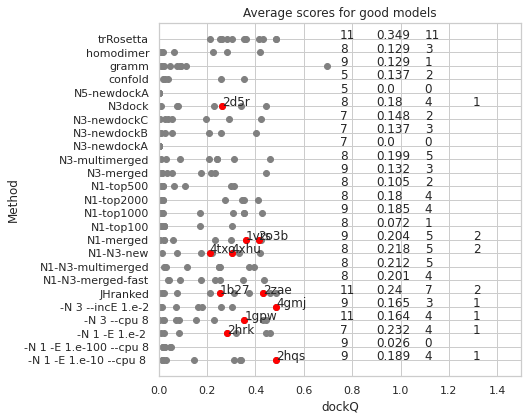

In [105]:
r = re.compile("^PDB.*|^TMd.*|^gramm|trRosetta|^pdb.*")
excludecolumns = list(filter(r.match, datasets)) # Read Note
print (excludecolumns)
includeTR=["pdbcontacts","PDBDOCK","TMdock-double"]
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best methods")

new_df=df.loc[(df.dockQ>cutoff) & (~df.JHparams.isin(excludecolumns))].sort_values('dockQ', ascending=False).drop_duplicates(["code"]).reset_index()
codes=new_df.CODE.unique()
#print(new_df)
#newdf.sort_values(["JHparams","dockQ","code"],inplace=True)

tempdf=df_max.loc[(df_max.CODE.isin(codes)) & (~df_max.params.isin(includeTR))].reset_index()
plt.scatter(tempdf.dockQ,tempdf.params,color="grey")
#print(tempdf[tempdf.params=="N1-top1000"])
plt.scatter(new_df.dockQ,new_df.params,color="red")
#print(new_df[new_df.params=="N1-top1000"])

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Average scores for good models")
ax.set_xlabel("dockQ")
ax.set_ylabel("Method")
ax.set(xlim=[0,1])
done={}
average={}
length={}
ax.set(xlim=[0,1.5])
for d in datasets: #~df.JHparams.isin(excludecolumns).unique():
    done[d]=0
    average[d]=df_max.loc[(df_max.CODE.isin(codes)) & (df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[(df_max.CODE.isin(codes)) & (df_max.params==d)]["dockQ"])
for i, txt in enumerate(tempdf.name):
    #print (i,txt, newdf.JHparams[i])
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(tempdf.loc[(tempdf.params==tempdf.params[i])&(tempdf.dockQ>cutoff)])
    
    #print (numhit,newdf.JHparams[i])
    if done[tempdf.params[i]]==0:
        done[tempdf.params[i]]=1
        ax.annotate(str(numhit),(1.1, tempdf.params[i]))
        #ax.annotate("0",(.1, tempdf.JHparams[i]))  
        ax.annotate(str(round(average[tempdf.params[i]],3)),(.9, tempdf.params[i]))          
        ax.annotate(str(round(length[tempdf.params[i]],3)),(.75, tempdf.params[i]))  
for d in datasets: #~df.JHparams.isin(excludecolumns).unique():
    done[d]=0
for i, txt in enumerate(new_df.name):
    #print (i,txt,newdf.dockQ[i], newdf.JHparams[i])
    sstr=txt[0:4]
    ax.annotate(sstr, (new_df.dockQ[i], new_df.params[i]))
    numhit=len(new_df.loc[new_df.params==new_df.params[i]])
    #numhit2=len(tempdf.loc[tempdf.JHparams==tempdf.params[i]])
    #print (numhit,newdf.JHparams[i])
    if done[new_df.params[i]]==0:
        done[new_df.params[i]]=1
        ax.annotate(str(numhit),(1.3, new_df.params[i]))  
        #ax.annotate(str(numhit2),(-0.1, new_df.JHparams[i]))


In [106]:
cutoff=0.1

In [107]:
JHsets=['-N 3 --cpu 8', 
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged',
       'N1-top1000', 'N1-top100', 'N1-top2000', 'N1-top500',  '-N 5 --cpu 8']

cutoff=0.1

In [108]:
goodmodels=df_max.loc[(df_max.dockQ>cutoff)&(df_max.params.isin(JHsets)) ]["CODE"].unique()

/home/arnee/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/arnee/.local/lib/python3.8/site-packages/numpy/core/_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/arnee/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/arnee/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/arnee/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


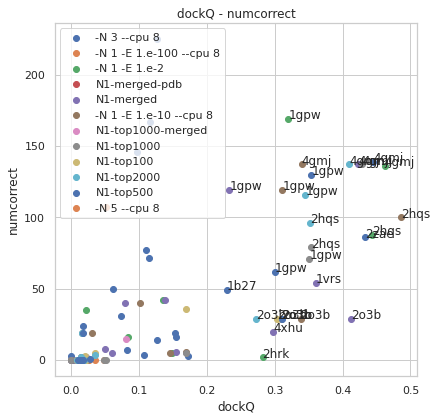

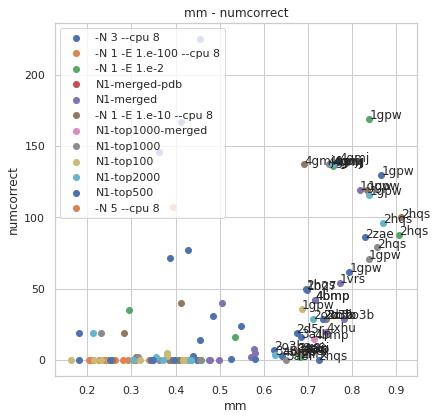

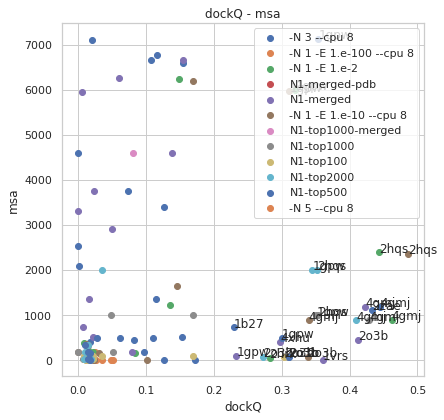

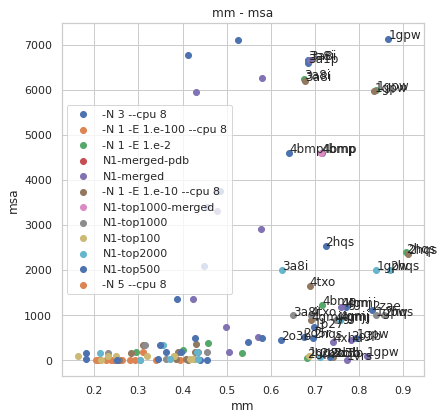

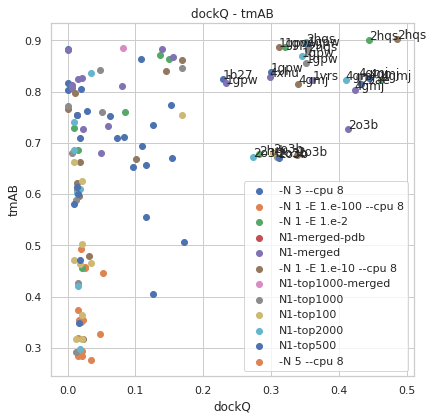

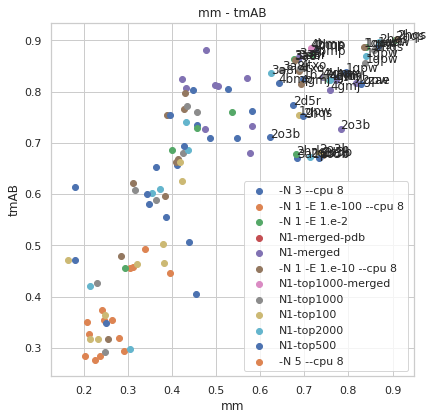

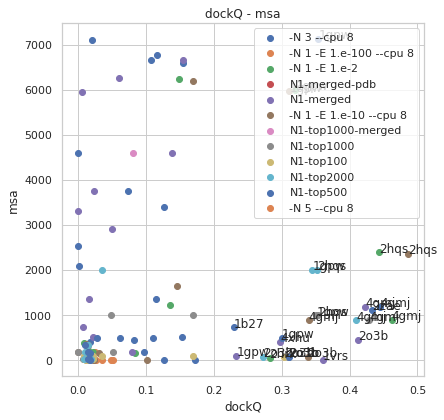

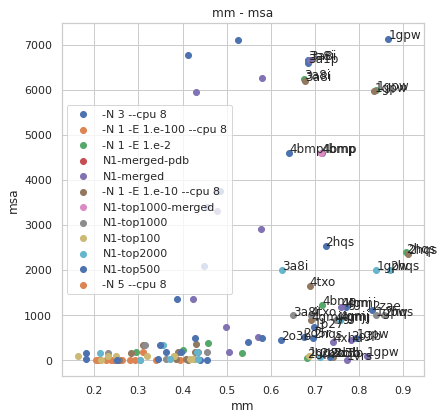

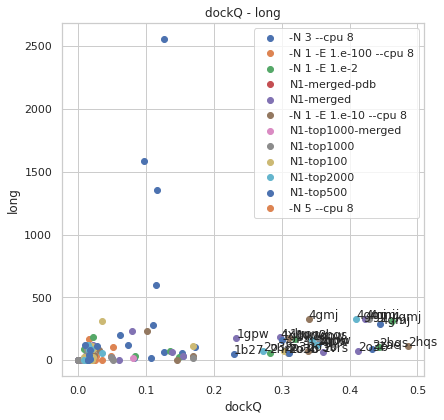

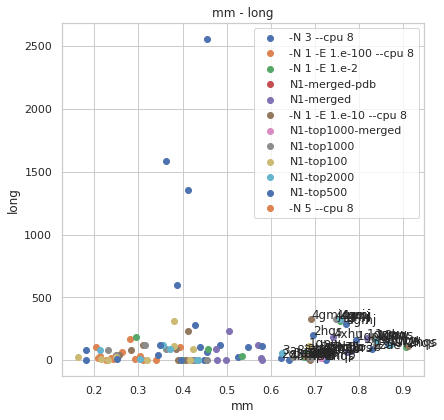

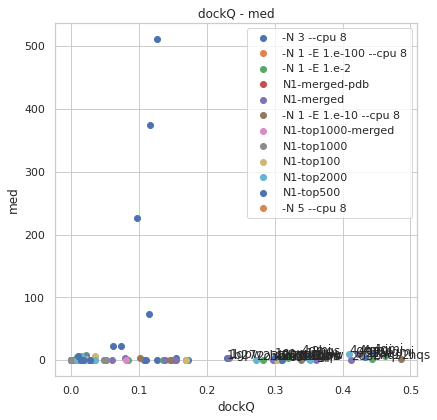

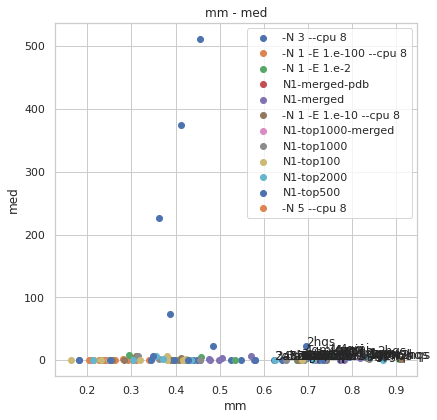

In [109]:
tempdf=df_max.loc[df_max.params.isin(JHsets)] 


tempdf=tempdf.loc[tempdf.CODE.isin(goodmodels)]
cf={"dockQ":0.2,"mm":0.6,"numcorrect":50}
for y in ["numcorrect","msa","tmAB","msa","long","med"]:
    for x in ["dockQ","mm","numcorrect"]:
        cutoff=cf[x]
        #print (Name)
         #if (Name != "lenA"):
        #    continue
        f, ax = plt.subplots(figsize=(6.5, 6.5))
        for d in JHsets:
            xdata=tempdf.loc[tempdf.params==d][x]
            ydata=tempdf.loc[tempdf.params==d][y]
            plt.scatter(xdata,ydata,label=d)
            cc=np.corrcoef(xdata,ydata)
            for i, txt in enumerate(tempdf.loc[tempdf.params==d].name):
                sstr=txt[0:4]
                if (xdata[i]>cutoff):
                    ax.annotate(sstr, (xdata[i], ydata[i]))
        ax.set_title(x + " - " + y )
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        ax.legend()
    plt.close()

In [110]:
datasets

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged',
       'N1-N3-merged-fast', 'N1-N3-new', 'N1-N3-multimerged',
       '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged', 'N1-top1000',
       'N1-top100', 'N1-top2000', 'N1-top500', 'N3dock',
       '-N 3 --incE 1.e-2', 'N3-merged', 'N3-multimerged', 'N3-newdockA',
       'N3-newdockB', 'N3-newdockC', 'N5-newdockA', 'trRosetta',
       'JHranked'], dtype=object)

In [111]:
goodmodels

array(['1gpw', '2hqs', '2o3b', '3a8i', '4c6t', '4gmj', '4txo', '2hrk',
       '4bmp', '1b27', '1gcq', '2d5r', '2wbw', '2x9a', '2zae', '3a1p',
       '3f1p', '4xs0', '1vrs', '4xhu'], dtype=object)

In [112]:
tempdf=df_max.loc[df_max.CODE.isin(codes)&(df_max.params.isin(pdbset))]
tempdf

,,name,lenA,lenB,msa,msaA,msaB,cdhit,dockQ,fnat,iRMS,...,CODE,params,tmAB,msaAB,tmAB_max,msaAB_max,tmAB_min,msaAB_min,numcorrect,len
JHparams,code,,,,,,,,,,,,,,,,,,,,,


In [113]:
df_max.loc[df_max.params=="N3-multimerged"]["dockQ"]

JHparams        code
N3-multimerged  1b27    0.242
                1buh    0.023
                1g6v    0.000
                1gcq    0.128
                1gg2    0.000
                        ...  
                4x6q    0.015
                4xhu    0.206
                4xoi    0.000
                4xs0    0.083
                4yoc    0.025
Name: dockQ, Length: 65, dtype: float64

-N 1 -E 1.e-2 
-N 3 --cpu 8
N1-N3-new


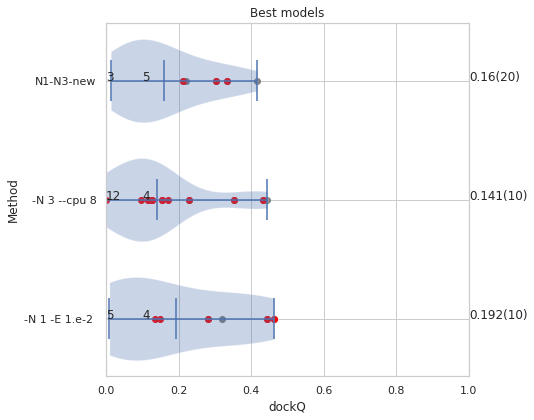

In [114]:
pdbset=['-N 3 --cpu 8', "-N 1 -E 1.e-2 " ,"N1-N3-new"]
cutoff=0.2
codes=goodmodels
# FInd best method for each model.
#codes=df_max.loc[df_max.params.isin(pdbset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
#tempdf=newdf.loc[newdf.JHparams.isin(pdbset)]
tempdf=df_max.loc[df_max.CODE.isin(codes)&(df_max.params.isin(pdbset))]
#best_df=newdf.sort_values("dockQ", ascending=False)
best_df=tempdf.sort_values('dockQ', ascending=False).drop_duplicates(['CODE']).reset_index()
best_df.sort_values("params")

#good_df=newdf.loc[(newdf.code.isin(codes))&(newdf.JHparams.isin(pdbset))].reset_index()
good_df=df_max.loc[df_max.CODE.isin(codes)&(df_max.params.isin(pdbset))&(df_max.dockQ>cutoff )].reset_index()

plt.scatter(good_df.dockQ,good_df.params,color="grey")
plt.scatter(best_df.dockQ,best_df.params,color="red")

#cc=np.corrcoef(newdf.dockQ,newdf.len)
#ax.legend()
ax.set_title("Best models")
ax.set_ylabel("Method")
ax.set_xlabel("dockQ")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
i=0
data=[]
for d in sorted(pdbset):
    done[d]=0
    average[d]=df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"].mean()
    length[d]=len(df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"])
    pos+=[i]
    data+=[df_max.loc[df_max.CODE.isin(codes)&(df_max.params==d)]["dockQ"]]
    i+=1
    print (d)
    
    
ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
for i, txt in enumerate(best_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.JHparams[i]))
    numhit=len(best_df.loc[best_df.params==best_df.params[i]])
    #print (numhit,newdf.params[i])
    if done[best_df.params[i]]==0:
        done[best_df.params[i]]=1
        ax.annotate(str(numhit),(.0, best_df.params[i]))
        ax.annotate(str(round(average[best_df.params[i]],3))+"("+str(length[good_df.params[i]])+")"
                    ,(1.0, best_df.params[i]))
for d in pdbset:
    done[d]=0
for i, txt in enumerate(good_df.name):
    #print (i,txt)
    sstr=txt[0:4]
    #ax.annotate(sstr, (newdf.dockQ[i], newdf.params[i]))
    numhit=len(good_df.loc[good_df.JHparams==good_df.params[i]])
    #print (numhit,newdf.params[i])
    if done[good_df.params[i]]==0:
        done[good_df.params[i]]=1
        ax.annotate(str(numhit),(.1, good_df.params[i]))
        #ax.annotate(str(round(average[good_df.JHparams[i]],3)),(1.0, good_df.JHparams[i]))
        #ax.annotate("("+str(length[good_df.JHparams[i]])+")",(1.2, good_df.JHparams[i]))
plt.savefig("N1-N3-violin.png")


In [115]:
#data_dirst


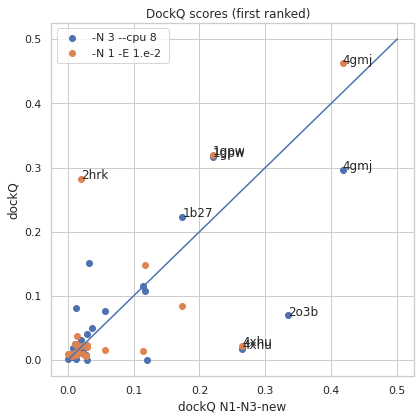

In [116]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
baseset="N1-N3-new"
for d in pdbset:
  
    if d==baseset:continue   
    #print (d)
    df_merged = pd.merge(data_first[baseset],data_first[d], on=['CODE'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.5]
y=[0,0.5]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (first ranked)  ")
ax.set_xlabel("dockQ "+baseset)
ax.set_ylabel("dockQ")
plt.savefig("N1-N3-scatter.png")
#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

KeyError: 'N1-merged-pdb'

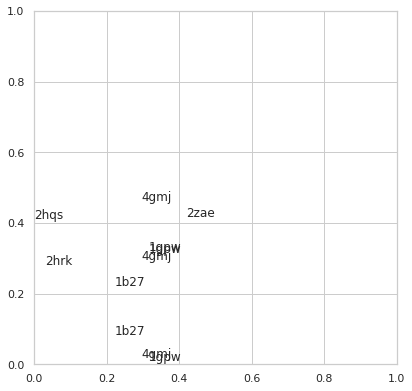

KeyError: 'N1-merged-pdb'

In [117]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in JHsets:
  
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_first[datasets[0]],data_first[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    #plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
#x=[0,0.3]
#y=[0,0.3]
#plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (first ranked)  ")
ax.set_xlabel("dockQ N1-N3 ")
ax.set_ylabel("dockQ")

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [118]:
goodmodels

array(['1gpw', '2hqs', '2o3b', '3a8i', '4c6t', '4gmj', '4txo', '2hrk',
       '4bmp', '1b27', '1gcq', '2d5r', '2wbw', '2x9a', '2zae', '3a1p',
       '3f1p', '4xs0', '1vrs', '4xhu'], dtype=object)

In [119]:
JHsets

['-N 3 --cpu 8',
 '-N 1 -E 1.e-100 --cpu 8',
 '-N 1 -E 1.e-2 ',
 'N1-merged-pdb',
 'N1-merged',
 '-N 1 -E 1.e-10 --cpu 8 ',
 'N1-top1000-merged',
 'N1-top1000',
 'N1-top100',
 'N1-top2000',
 'N1-top500',
 '-N 5 --cpu 8']

In [120]:
JHsets1=['-N 3 --cpu 8',
 '-N 1 -E 1.e-100 --cpu 8',
 '-N 1 -E 1.e-2 ',
 'N1-merged-pdb',
 'N1-merged',
 '-N 1 -E 1.e-10 --cpu 8 ']

In [121]:
JHsets2=[
 'N1-top1000-merged',
 'N1-top1000',
 'N1-top100',
 'N1-top2000',
 'N1-top500',
 '-N 5 --cpu 8']

In [122]:
JHsets=['-N 3 --cpu 8',
 '-N 1 -E 1.e-2 --cpu 8',
 '-N 1 -E 1.e-10 --cpu 8 ',
 '-N 5 --cpu 8']
good_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets))].reset_index()


In [123]:
train_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets1))].reset_index()
test_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets2))].reset_index()

In [124]:
good_df=df_first.loc[(df_first.code.isin(goodmodels)&(df_first.JHparams.isin(JHsets)))].reset_index()

In [125]:
good_df=df_first.loc[(df_first.JHparams.isin(JHsets))].reset_index()

In [126]:
good_df

,index,name,JHparams,lenA,lenB,msa,msaA,msaB,cdhit,dockQ,...,CODE,params,tmAB,msaAB,tmAB_max,msaAB_max,tmAB_min,msaAB_min,numcorrect,len
0,0,1b27_u1_A-1b27_u2_A,-N 3 --cpu 8,109,90,733,1484,2034,654,0.223,...,1b27,-N 3 --cpu 8,0.824750,1759.0,0.85428,2034.0,0.79522,1484.0,49.025,199
1,2,1bdj_u1_A-1bdj_u2_A,-N 3 --cpu 8,129,118,5651,349880,23051,5071,0,...,1bdj,-N 3 --cpu 8,0.861435,186465.5,0.92240,349880.0,0.80047,23051.0,0,247
2,3,1buh_u1_A-1buh_u2_A,-N 3 --cpu 8,291,72,1177,555226,1820,548,0,...,1buh,-N 3 --cpu 8,0.560760,278523.0,0.73259,555226.0,0.38893,1820.0,0,363
3,5,1bvn_u1_A-1bvn_u2_A,-N 3 --cpu 8,496,75,95,52623,123,85,0.006,...,1bvn,-N 3 --cpu 8,0.619740,26373.0,0.70905,52623.0,0.53043,123.0,0,571
4,7,1clv_u1_A-1clv_u2_A,-N 3 --cpu 8,471,33,1,53450,0,1,0.007,...,1clv,-N 3 --cpu 8,0.225975,26725.0,0.26604,53450.0,0.18591,0.0,0,504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,2706,4y7m_u1_A-4y7m_u2_A,-N 1 -E 1.e-10 --cpu 8,240,136,1,247,4973,1,0.019,...,4y7m,-N 1 -E 1.e-10 --cpu 8,0.318185,2610.0,0.32457,4973.0,0.31180,247.0,0,376
342,2709,4yoc_u1_A-4yoc_u2_A,-N 1 -E 1.e-10 --cpu 8,905,530,13,10092,2065,13,0.006,...,4yoc,-N 1 -E 1.e-10 --cpu 8,0.199905,6078.5,0.20828,10092.0,0.19153,2065.0,0,1435
343,2711,5brr_u1_A-5brr_u2_A,-N 1 -E 1.e-10 --cpu 8,378,266,448,10219,28413,346,0.008,...,5brr,-N 1 -E 1.e-10 --cpu 8,0.701015,19316.0,0.70288,28413.0,0.69915,10219.0,76,644
344,2712,5cec_u1_A-5cec_u2_A,-N 1 -E 1.e-10 --cpu 8,403,191,8,200,59695,7,0.018,...,5cec,-N 1 -E 1.e-10 --cpu 8,0.487430,29947.5,0.68790,59695.0,0.28696,200.0,0,594


In [127]:
cutoff

0.2

AttributeError: 'float' object has no attribute 'shape'

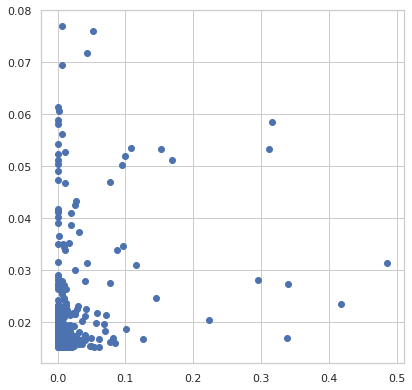

AttributeError: 'float' object has no attribute 'shape'

In [128]:
ydata=good_df.dockQ
cols=["lenA","lenB","msa","long","med","longA","medA","longB","medB","tmA","tmB"]

#xdata=good_df[["lenA","lenB","long","med"]]
#cols=["longA","longB","medA","medB","tmA","tmB"]
cols=["med","long","msa"]
#cols=["msa"]
xdata=good_df[cols]


reg.fit(xdata,ydata)
ypred = reg.predict(xdata)
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(ydata,ypred)
cc=np.corrcoef(ydata,ypred)
ax.set_xlabel("dockQ")
ax.set_ylabel("predicted dockQ")
(i,j,dockq,mm)=get_ranks(good_df,ypred)
#print(i,j,k/i)
ax.set_title("CC" + " " + str(round(cc[0,1],3))
            + " Good: " + str(round(j/i,3)) + " Loss: " + str(round(dockq/i,3))
             + " , " + str(round(mm/i,3))
             + " Test: " + str(i)
            )


In [129]:
print('Intercept: \n', reg.intercept_)
print('Coefficients: \n', reg.coef_)

Intercept: 
 0.015148262954868586
Coefficients: 
 [-9.68374617e-05  2.55119537e-05  5.68618917e-06]


In [130]:

for s in JHsets:
    set_df=good_df.loc[good_df.params==s]
    ypred=set_df["dockQ"].to_list()
    (i,j,dockq,mm)=get_ranks(set_df,ypred)
    print (s,i,j,dockq,mm)

-N 3 --cpu 8 4 4 0.0 0.0
-N 1 -E 1.e-2 --cpu 8 0 0 0 0
-N 1 -E 1.e-10 --cpu 8  4 4 0.0 0.0
-N 5 --cpu 8

 0 0 0 0


AttributeError: 'float' object has no attribute 'shape'

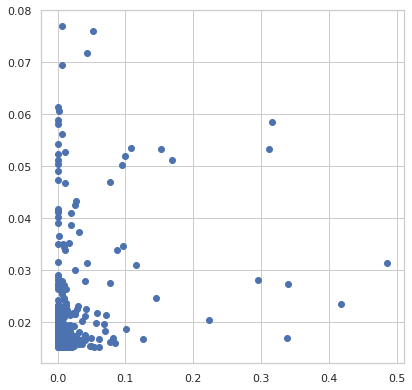

AttributeError: 'float' object has no attribute 'shape'

In [131]:
xdata=good_df[cols]
ydata=good_df.dockQ

ypred = reg.predict(xdata)
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(ydata,ypred)
cc=np.corrcoef(ydata,ypred)
ax.set_title("CC" + " " + str(cc[0,1]))
ax.set_xlabel("dockQ")
ax.set_ylabel("predicted dockQ")


In [132]:
good_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets))].reset_index()
good_df

,index,name,JHparams,lenA,lenB,msa,msaA,msaB,cdhit,dockQ,...,CODE,params,tmAB,msaAB,tmAB_max,msaAB_max,tmAB_min,msaAB_min,numcorrect,len
0,0,1b27_u1_A-1b27_u2_A,-N 3 --cpu 8,109,90,733,1484,2034,654,0.223,...,1b27,-N 3 --cpu 8,0.824750,1759.0,0.85428,2034.0,0.79522,1484.0,49.025,199
1,21,1gcq_u1_A-1gcq_u2_A,-N 3 --cpu 8,66,57,1365,77497,77704,765,0.115,...,1gcq,-N 3 --cpu 8,0.539990,77600.5,0.63426,77704.0,0.44572,77497.0,71.76,123
2,25,1gpw_u1_A-1gpw_u2_A,-N 3 --cpu 8,252,204,7137,58466,67629,5348,0.316,...,1gpw,-N 3 --cpu 8,0.885175,63047.5,0.89229,67629.0,0.87806,58466.0,96.033,456
3,69,1vrs_u1_A-1vrs_u2_A,-N 3 --cpu 8,124,117,2091,100319,2803,1978,0,...,1vrs,-N 3 --cpu 8,0.802425,51561.0,0.80545,100319.0,0.79940,2803.0,0,241
4,113,2d5r_u1_A-2d5r_u2_A,-N 3 --cpu 8,265,121,521,6154,1771,226,0.019,...,2d5r,-N 3 --cpu 8,0.774350,3962.5,0.87286,6154.0,0.67584,1771.0,5.994,386
5,125,2hqs_u1_A-2hqs_u2_A,-N 3 --cpu 8,398,109,2460,376708,32336,2144,0,...,2hqs,-N 3 --cpu 8,0.879120,204522.0,0.90440,376708.0,0.85384,32336.0,0,507
6,127,2hrk_u1_A-2hrk_u2_A,-N 3 --cpu 8,181,121,3760,18121,4930,3300,0.031,...,2hrk,-N 3 --cpu 8,0.709645,11525.5,0.72697,18121.0,0.69232,4930.0,0,302
7,143,2o3b_u1_A-2o3b_u2_A,-N 3 --cpu 8,240,144,456,5431,518,306,0.07,...,2o3b,-N 3 --cpu 8,0.706510,2974.5,0.77479,5431.0,0.63823,518.0,6.992,384
8,161,2wbw_u1_A-2wbw_u2_A,-N 3 --cpu 8,186,125,6,76,113530,6,0.081,...,2wbw,-N 3 --cpu 8,0.506215,56803.0,0.68205,113530.0,0.33038,76.0,0.994,311
9,167,2x9a_u1_A-2x9a_u2_A,-N 3 --cpu 8,103,63,4,2604,18,4,0.126,...,2x9a,-N 3 --cpu 8,0.404970,1311.0,0.49273,2604.0,0.31721,18.0,13.986,166


In [133]:
# Now we try all combinations - no plots
set1_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets1))].reset_index()
set2_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets2))].reset_index()
good_df=df_first.loc[(df_first.code.isin(goodmodels))&(df_first.JHparams.isin(JHsets))].reset_index()

cols=["lenA","lenB","msa","long","med","longA","medA","longB","medB","tmA","tmB"]
ydata=good_df.dockQ

res={}
maxvalue=0
for c in cols:
    xdata=good_df[[c]]
    reg.fit(xdata,ydata)
    ypred = reg.predict(xdata)
    print (c,round(np.corrcoef(ydata,ypred)[0,1],3))
    res[c]=np.corrcoef(ydata,ypred)[0,1]
    maxvalue=max(res[c],maxvalue)    
for c in cols:
    for d in cols:
        xdata=good_df[[c,d]]
        reg.fit(xdata,ydata)
        ypred = reg.predict(xdata)
        #print (c,d,round(np.corrcoef(ydata,ypred)[0,1],3))
        res[c+d]=np.corrcoef(ydata,ypred)[0,1]
        #if (res[c+d]-maxvalue>0.0):
        #    print (c,d,round(np.corrcoef(ydata,ypred)[0,1],3))
        (i,j,k,l)=get_ranks(good_df,ypred)
        print (c,d,i,j,k,l)

AttributeError: 'float' object has no attribute 'shape'

In [134]:

print('Intercept: \n', reg.intercept_)
print('Coefficients: \n', reg.coef_)


Intercept: 
 0.07475359551485539
Coefficients: 
 [0.00022776]


Text(0, 0.5, 'predicted dockQ')

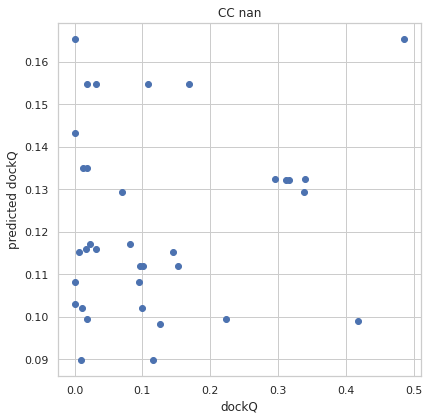

In [135]:
ypred = reg.predict(xdata)
f, ax = plt.subplots(figsize=(6.5, 6.5))
plt.scatter(ydata,ypred)
#cc=np.corrcoef(ydata,ypred)
ax.set_title("CC" + " " + str(cc[0,1]))
ax.set_xlabel("dockQ")
ax.set_ylabel("predicted dockQ")


In [136]:
newdf=df.loc[df.JHparams=="trRosetta"]
plt.scatter(newdf.csv,newdf.)

SyntaxError: invalid syntax (<ipython-input-136-1bbe5c8e123e>, line 2)

In [137]:
newdf[["CODE","dockQ","csv","tmAB","long"]].sort_values("csv")

KeyError: "['csv'] not in index"

In [138]:
JHsets=['-N 3 --cpu 8', 
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-merged-pdb',
       'N1-merged', '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged',
       'N1-top1000', 'N1-top100', 'N1-top2000', 'N1-top500',  '-N 5 --cpu 8']


Text(0.5, 0, 'cdhit')

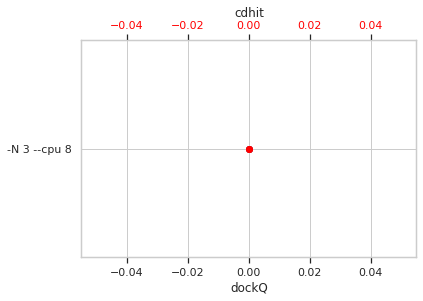

In [139]:
newdf=df.loc[(df.CODE=="4etw")&(df.JHparams.isin(JHsets))].reset_index()
fig, ax1 = plt.subplots()
ax1.set_xlabel('dockQ')
ax1.scatter(newdf.dockQ,newdf.JHparams)
ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis
ax2.scatter(newdf.long,newdf.JHparams,color="red")
ax2.tick_params(axis='x', labelcolor="red")
ax2.set_xlabel('cdhit')

Text(0.5, 0, 'cdhit')

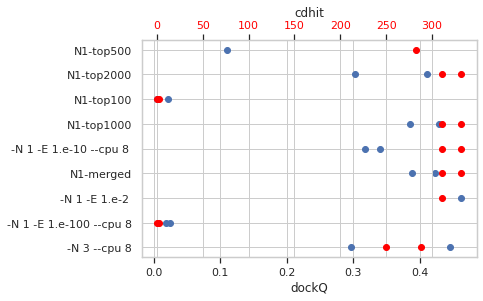

In [140]:
newdf=df.loc[(df.CODE=="4gmj")&(df.JHparams.isin(JHsets))].reset_index()
fig, ax1 = plt.subplots()
ax1.set_xlabel('dockQ')
ax1.scatter(newdf.dockQ,newdf.JHparams)
ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis
ax2.scatter(newdf.long,newdf.JHparams,color="red")
ax2.tick_params(axis='x', labelcolor="red")
ax2.set_xlabel('cdhit')

# bes models to test 2zae 4gmj
# Bad model 4etw

In [141]:
df_max.loc[(df_max.params=="trRosetta") & (df_max.dockQ==0)]

name  lenA  lenB     msa      msaA      msaB  \
JHparams  code                                                                
trRosetta 1bdj  1bdj_u1_A-1bdj_u2_A   129   118  5651.0  349880.0   23051.0   
          1yvb  1yvb_u2_A-1yvb_u1_A   237   237   482.0   19991.0   19991.0   
          1z5y  1z5y_u2_A-1z5y_u1_A   150   150  2149.0  132152.0  132152.0   
          3cu1  3cu1_u2_A-3cu1_u1_A   132   132   326.0  220090.0  224349.0   
          3fap  3fap_u2_A-3fap_u1_A   108   108  1208.0   34346.0   34346.0   
          3hzi  3hzi_u2_A-3hzi_u1_A   410   410  1958.0  104599.0  104599.0   
          3oed  3oed_u2_A-3oed_u1_A   295   295   358.0   41324.0   41324.0   
          3qc8  3qc8_u2_A-3qc8_u1_A   169   169  1288.0    8453.0    8453.0   
          3rj3  3rj3_u2_A-3rj3_u1_A   295   295   353.0   54903.0   54903.0   
          4emj  4emj_u2_A-4emj_u1_A   403   403  6281.0  227257.0  213507.0   
          4etw  4etw_u2_A-4etw_u1_A   252   252  7563.0  252977.0  252977.0   
          4pou  4pou_u2_A-4pou_u1_A   125   125   135.0   44299.0   51048.0   
          4pw9  4pw9_u2_A-4pw9_u1_A   366   366  2897.0   42875.0   42875.0   
          4xoi  4xoi_u2_A-4xoi_u1_A   215   215   350.0  186998.0  186998.0   

                cdhit  dockQ  fnat     iRMS  ...  CODE     params      tmAB  \
JHparams  code                               ...                              
trRosetta 1bdj   5071    0.0   0.0  211.527  ...  1bdj  trRosetta  0.861435   
          1yvb    357    0.0   0.0  397.197  ...  1yvb  trRosetta  0.844900   
          1z5y   2113    0.0   0.0  254.762  ...  1z5y  trRosetta  0.830655   
          3cu1    186    0.0   0.0  233.974  ...  3cu1  trRosetta  0.672840   
          3fap    573    0.0   0.0  183.557  ...  3fap  trRosetta  0.839040   
          3hzi   1920    0.0   0.0  696.403  ...  3hzi  trRosetta  0.789265   
          3oed    261    0.0   0.0  515.880  ...  3oed  trRosetta  0.596385   
          3qc8    503    0.0   0.0  283.233  ...  3qc8  trRosetta  0.698285   
          3rj3    243    0.0   0.0  506.753  ...  3rj3  trRosetta  0.621845   
          4emj   5675    0.0   0.0  681.898  ...  4emj  trRosetta  0.881245   
          4etw   7130    0.0   0.0  439.795  ...  4etw  trRosetta  0.867955   
          4pou    108    0.0   0.0  220.541  ...  4pou  trRosetta  0.711820   
          4pw9   2392    0.0   0.0  611.834  ...  4pw9  trRosetta  0.766215   
          4xoi    172    0.0   0.0  381.998  ...  4xoi  trRosetta  0.668615   

                   msaAB  tmAB_max  msaAB_max  tmAB_min  msaAB_min  \
JHparams  code                                                       
trRosetta 1bdj  186465.5   0.92240   349880.0   0.80047    23051.0   
          1yvb   12997.5   0.86379    19991.0   0.83314     6004.0   
          1z5y   67540.0   0.87861   132152.0   0.79121     2928.0   
          3cu1  114811.0   0.78824   224349.0   0.63179     5273.0   
          3fap   17912.5   0.87823    34346.0   0.79985     1479.0   
          3hzi   54804.0   0.84995   104599.0   0.74204     5009.0   
          3oed   25328.0   0.76465    41324.0   0.43932     9332.0   
          3qc8    7107.0   0.84873     8453.0   0.55399     5761.0   
          3rj3   32117.5   0.76963    54903.0   0.48427     9332.0   
          4emj  131593.0   0.90199   227257.0   0.86593    35929.0   
          4etw  147158.0   0.88718   252977.0   0.84893    41339.0   
          4pou   26168.5   0.79574    51048.0   0.64568     1289.0   
          4pw9   27701.5   0.83664    42875.0   0.70508    12528.0   
          4xoi   94216.5   0.82437   186998.0   0.64075     1435.0   

                numcorrect  len  
JHparams  code                   
trRosetta 1bdj         0.0  247  
          1yvb         0.0  346  
          1z5y         0.0  272  
          3cu1         0.0  233  
          3fap         0.0  201  
          3hzi         0.0  480  
          3oed         0.0  426  
          3qc8         0.0  251  
          3rj3         0.0  421  
      

66 205
0      1.8
2        0
3      1.6
5        0
7        0
      ... 
399      0
401    0.5
403    0.3
405      1
407    0.7
Name: hhprob, Length: 205, dtype: object
0          50
2           0
3          30
5       31.25
7      55.556
        ...  
399         0
401    53.846
403    33.333
405         0
407        40
Name: seqid, Length: 205, dtype: object
0      0.633468
2      3.999957
3     -0.070581
5      0.361728
7     -0.455932
         ...   
399    3.999957
401   -0.318759
403    1.278754
405    3.999957
407    1.832509
Name: logEvalue, Length: 205, dtype: float64
0      0.223
2          0
3          0
5      0.006
7      0.007
       ...  
399        0
401    0.012
403        0
405    0.008
407        0
Name: dockQ, Length: 205, dtype: object


<ipython-input-154-bbc1e4ee72ec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["logEvalue"]=np.log10(df_test.evalue.astype('float64')).clip(+10,-10)
<ipython-input-154-bbc1e4ee72ec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["logHHEvalue"]=np.log10(df_test.hhevalue.astype('float64')).clip(+10,-10)


TypeError: No loop matching the specified signature and casting was found for ufunc add

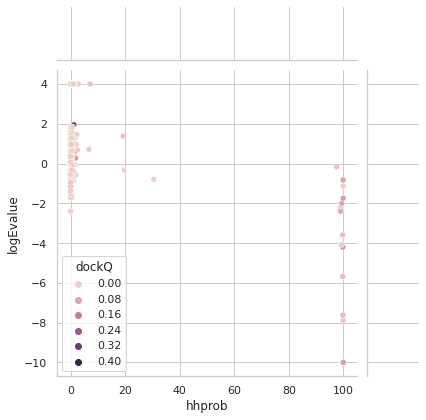

TypeError: No loop matching the specified signature and casting was found for ufunc add

In [154]:
df_test= data_first["-N 3 --cpu 8"]
df_test["logEvalue"]=np.log10(df_test.evalue.astype('float64')).clip(+10,-10)
df_test["logHHEvalue"]=np.log10(df_test.hhevalue.astype('float64')).clip(+10,-10)
#plt.scatter(df_test.tmB,df_test.tmA)
cutoff=0.5
num=len(df_test.loc[df_test.hhprob>cutoff])
tot=len(df_test)


print (num,tot)
print (df_test.hhprob)
print (df_test.seqid)
print (df_test.logEvalue)
print (df_test.dockQ)

sns_plot = sns.jointplot(data=df_test, x="hhprob", y="logEvalue",hue="dockQ")
#sns_plot.title("Homologous pairs: "+str(num)+" of "+str(tot))
sns_plot.savefig("hhpred-logEvalue.png")





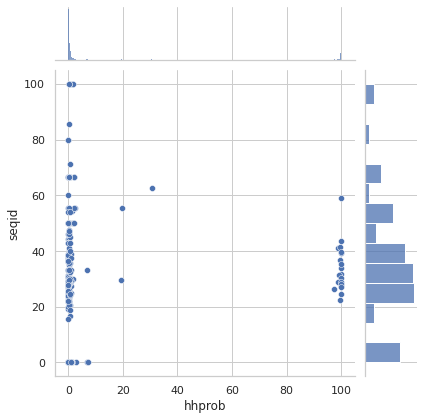

In [163]:
sns_plot = sns.jointplot(data=df_test, x="hhprob", y="seqid") # ,hue="dockQ")
#sns_plot = sns.displot(data=df_test, x="hhprob", y="seqid" ,hue="dockQ")
#.set_title("Homologous pairs: "+str(num)+" of "+str(tot))
sns_plot.savefig("hhpred-seqid.png")


<ipython-input-168-017405ae5656>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Long"]=(df_test.long.astype('float64')).clip(0,500)
/home/arnee/.local/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-168-017405ae5656>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["LogLong"]=np.log10(df_test.long.astype('float64')).clip(0,2.5)


TypeError: No loop matching the specified signature and casting was found for ufunc add

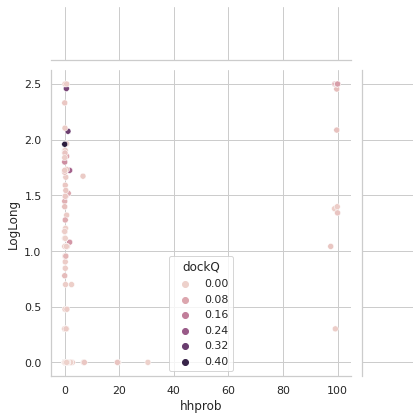

TypeError: No loop matching the specified signature and casting was found for ufunc add

In [168]:
df_test["Long"]=(df_test.long.astype('float64')).clip(0,500)
df_test["LogLong"]=np.log10(df_test.long.astype('float64')).clip(0,2.5)
sns_plot = sns.jointplot(data=df_test, x="hhprob", y="LogLong" ,hue="dockQ")
sns_plot.savefig("hhpred-long.png")
